# Analysis pipeline for male _Ae. aegypti_ reproductive tract RNAseq
### Degner _et al_.

### Load the required packages and raw data files:

Load the reuired packages for the analyses/plotting:

In [1]:
req_packages = c("ballgown", "Biobase", "cluster", "cowplot", "cummeRbund", 
                 "data.table", "DESeq", "edgeR", "genefilter", "ggplot2", 
                 "ggrepel", "ggthemes", "ggthemr", "Glimma", 
                 "GO.db", "goseq", "gplots", "grid", "gridExtra", 
                 "heatmap3", "imager", "plotly", "qvalue", "RColorBrewer", 
                 "reshape", "Rmisc", "splitstackshape", "statmod", 
                 "VennDiagram")

lapply(req_packages, require, character.only = TRUE)

# The Cowplot package changes the default themes of ggplot2. Set the default theme like so:
theme_set(theme_gray())

Loading required package: ballgown

Attaching package: ‘ballgown’

The following object is masked from ‘package:base’:

    structure

Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mget, order,
    paste, pmax, pmax.int, pmin, pmin.int, Position, rank, rbind,
    Reduce, rownames, sapply, setdiff, sort, table, tapply, union,
    unique, un

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

[[14]]
[1] TRUE

[[15]]
[1] TRUE

[[16]]
[1] TRUE

[[17]]
[1] TRUE

[[18]]
[1] TRUE

[[19]]
[1] TRUE

[[20]]
[1] TRUE

[[21]]
[1] TRUE

[[22]]
[1] TRUE

[[23]]
[1] TRUE

[[24]]
[1] TRUE

[[25]]
[1] TRUE

[[26]]
[1] TRUE

[[27]]
[1] TRUE

[[28]]
[1] TRUE

[[29]]
[1] TRUE

In addition, several convenient plotting and annotation functions are available in the `Functions2.R` file, so load as source:

In [2]:
source("Functions2.R")

Now load the raw count matrix

In [3]:
countsMatrix = read.csv(file = "expression_data/gene_counts.csv", header = T, sep = ",", row.names = 1)
transcriptCounts = read.csv(file = "expression_data/transcript_counts.csv", header = T, sep = ",", row.names = 1)

There's a bunch of annotation files that are needed. First, the gene features file has the coordinate and gene IDs from the RNAseq run:

In [5]:
gene.features = read.table("annotation/features.txt", header = T)

ref_gene_ids = subset(gene.features, ref_gene_id != "NA")
genbank_proteins = read.csv("annotation/Protein_annotation.txt", header =T, sep = "\t")
refseq_ids = read.csv("annotation/VB.L5.transcript_gene_RefSeq.txt", header = T, sep = "\t", na.strings = "", stringsAsFactors=FALSE)
trinotate = read.csv("annotation/Trinotate_report.xls", header = T, sep = "\t", na.strings = "", stringsAsFactors=FALSE)
GO_info = read.csv("annotation/Trinotate_report.xls.gene_ontology", header=F, row.names=1, sep = "\t", stringsAsFactors=F)
trans_lengths = read.csv("annotation/transcript_lengths.txt", header = T, sep = " ")
AaegL5_annotation = read.csv("annotation/AaegL5.gene.annotation.txt", header = T, sep = "\t")
AgamP4_annotation = read.csv("annotation/AgamP4.protein.annotation.txt", header = T, sep = "\t")

Also upload the Vectorbase Gene Ontology info (only ~10K genes have GO annotations).

In [6]:
VB_GO_info = read.csv("annotation/VB_GO_info.txt", header = F, sep = "\t")
VB_GO_info = VB_GO_info[!duplicated(VB_GO_info$V1),]
rownames(VB_GO_info) = VB_GO_info$V1
VB_GO_info = subset(VB_GO_info, select = "V2")

Now we can subset and combine `gene_id`'s with annotation information:

In [7]:
ref_to_gene = unique(subset(gene.features, select = c("gene_id", "ref_gene_id")))
tmpRef = unique(subset(refseq_ids, select = c("gene_ID", "RefSeq_protein_name")))
ref_to_gene = merge(tmpRef, ref_to_gene, by.x="gene_ID", by.y="ref_gene_id", all = TRUE)
ref_to_gene = merge(ref_to_gene, genbank_proteins, by.x="RefSeq_protein_name", by.y="protein_name", all = TRUE)
ref_to_gene = merge(ref_to_gene, AaegL5_annotation, by.x="gene_ID", by.y="gene_id", all = TRUE)
colnames(ref_to_gene) = c("gene_ID", "RefSeq_protein", "mstrg_ID", "transcript_ID", "loc_ID",    "GenBank_description", "gene_name", "VB_description")
geneFeatures = unique(subset(ref_to_gene, select = c("mstrg_ID", "gene_ID", "loc_ID", "gene_name", "GenBank_description")))

Load OrthoDB analysis results here:

In [8]:
orthoDB = read.csv(file = "proteomics/ortho_aedes1_ids.txt", header = T, sep = "\t")

For later, we'll need the gene lengths:

In [9]:
tmpMrge = merge(trans_lengths, gene.features)
tmpMrge = as.data.table(subset(tmpMrge, select = c("length", "gene_id")))
# tmpMrge = subset(tmpMrge, grepl("AAEL", tmpMrge$ref_gene_id))
gene_lengths = tmpMrge[tmpMrge[, .I[which.max(length)], by=gene_id]$V1]
# gene_lengths = subset(gene_lengths, ref_gene_id %in% rownames(countsMatrix))

Finally, we'll input the sample information and add sample features based on sample names:

In [10]:
sampleData = read.table("annotation/sample_replicate_map.txt", header=F, check.names=F, fill=T)
sampleData = sampleData[sampleData[,2] != '',]
colnames(sampleData) = c("Sample", "Replicate")
## Add a tissue column
sampleData$Tissue = ifelse(grepl("MAG", sampleData$Sample, ignore.case = F), "MAG", ifelse(grepl("TS", sampleData$Sample, ignore.case = F), "Testes", ifelse(grepl("testes", sampleData$Sample, ignore.case = F), "Testes", ifelse(grepl("RT", sampleData$Sample, ignore.case = F), "fRT", ifelse(grepl("CR", sampleData$Sample, ignore.case = F), "carcass", "Sperm")))))
## Add a source column
sampleData$Source = ifelse(grepl("RT", sampleData$Sample, ignore.case = F), "Alfonso-Parra", ifelse(grepl("MAG", sampleData$Sample, ignore.case = F), "Degner", ifelse(grepl("testes", sampleData$Sample, ignore.case = F), "Degner", ifelse(grepl("Ma_CR", sampleData$Sample, ignore.case = F), "Akbari", ifelse(grepl("Ma_TS", sampleData$Sample, ignore.case = F), "Akbari", "Sutton")))))

For subsequent analysis we have to filter out genes with very low expression:

In [11]:
all.CPM <- cpm(countsMatrix)
thresh <- all.CPM > 5
keep <- rowSums(thresh) >= 4
counts.keep <- countsMatrix[keep,]
dim(counts.keep)

[1] 12340    26

Using the threshold above applies well for Ethan's data (note the 3' read difference with other samples). If we filter low expression data at 10 CPM, that's equal to an average of 150 reads/gene for Ethan's data.

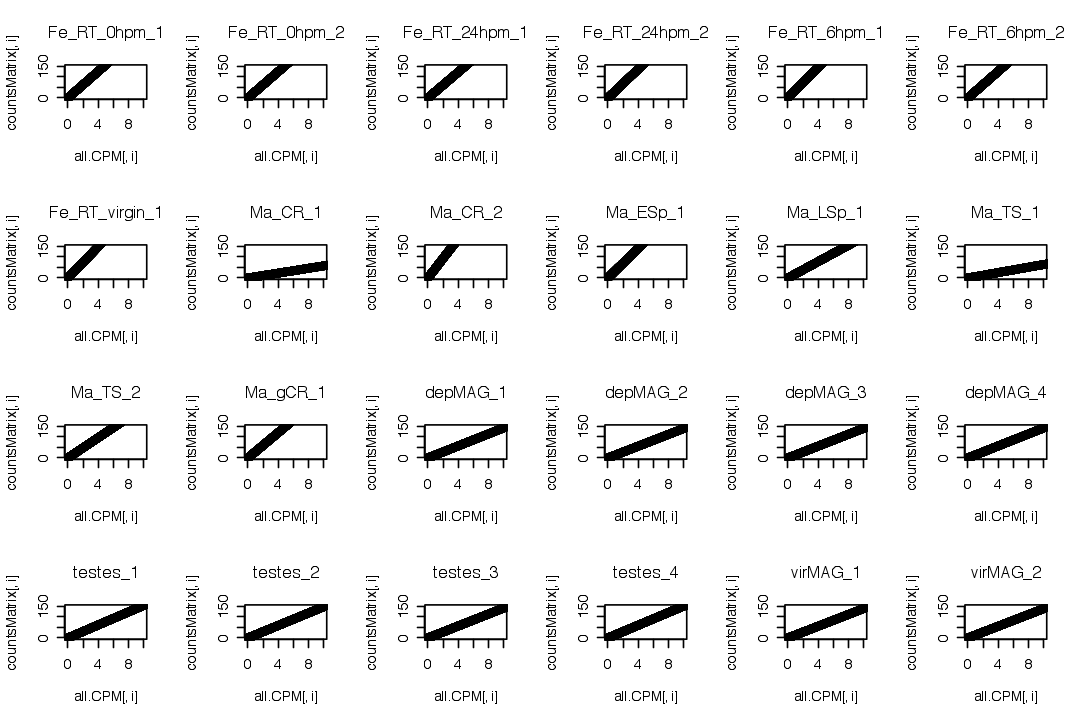

In [12]:
options(repr.plot.width = 9, repr.plot.height = 6)
par(mfrow=c(4,6))
for(i in seq(from=1, to=24, by=1)){
  plot(all.CPM[,i],countsMatrix[,i], xlim=c(0,10), ylim=c(0,150))
  title(colnames(all.CPM)[i])
}

To obtain a TPM matrix of the combined data, we'll need to separate the 3'RNAseq data (Ethan's) from the rest, obtain TPM normalizations separately, then combine the matrices. First, we'll do Ethan's data (pick any number for gene length. Here I chose the average gene length of 2922):

In [13]:
ethan.countsMatrix = subset(countsMatrix, select=c("depMAG_1", "depMAG_2", "depMAG_3", "depMAG_4", "testes_1", "testes_2", "testes_3", "testes_4", "virMAG_1", "virMAG_2", "virMAG_3", "virMAG_4"))
ethan.geneTPM <- apply(ethan.countsMatrix, 2, function(x) tpm(x, 2922))
ethan.geneTPM = as.data.frame(ethan.geneTPM)

Now we'll TPM normalize the remainder. For that we'll need to match the gene length data frame with the counts matrix data frame:

In [14]:
rest.countsMatrix = subset(countsMatrix, select=c("Fe_RT_0hpm_1", "Fe_RT_0hpm_2", "Fe_RT_24hpm_1", "Fe_RT_24hpm_2", "Fe_RT_6hpm_1", "Fe_RT_6hpm_2", "Fe_RT_virgin_1", "Ma_CR_1", "Ma_CR_2", "Ma_ESp_1", "Ma_LSp_1", "Ma_TS_1", "Ma_TS_2", "Ma_gCR_1"))
rest.geneTPM <- apply(rest.countsMatrix, 2, function(x) tpm(x, gene_lengths$length))
rest.geneTPM = as.data.frame(rest.geneTPM)

Now we can combine both TPM matrices:

In [15]:
geneTPM = cbind(rest.geneTPM, ethan.geneTPM)

We'll need to reshape the CPM and TPM matrices to calculate means and for convenient heatmap and gene plotting later.
First the CPM amtrix:

In [16]:
tmp.cpmMatrix<-all.CPM
colnames(tmp.cpmMatrix) <- sampleData$Sample
tmp.cpmMatrix.m <- as.data.frame(melt(as.matrix(tmp.cpmMatrix)))
colnames(tmp.cpmMatrix.m) <- c("gene_id", "sample", "CPM")

tmp.cpmMatrix.m$Tissue = ifelse(grepl("MAG", tmp.cpmMatrix.m$sample, ignore.case = F), "MAG", ifelse(grepl("TS", tmp.cpmMatrix.m$sample, ignore.case = F), "Testes", ifelse(grepl("testes", tmp.cpmMatrix.m$sample, ignore.case = F), "Testes", ifelse(grepl("RT", tmp.cpmMatrix.m$sample, ignore.case = F), "fRT", ifelse(grepl("CR", tmp.cpmMatrix.m$sample, ignore.case = F), "carcass", "Sperm")))))

tmp.cpmMatrix.m$Source = ifelse(grepl("RT", tmp.cpmMatrix.m$sample, ignore.case = F), "Alfonso-Parra", ifelse(grepl("MAG", tmp.cpmMatrix.m$sample, ignore.case = F), "Degner", ifelse(grepl("testes", tmp.cpmMatrix.m$sample, ignore.case = F), "Degner", ifelse(grepl("Ma_CR", tmp.cpmMatrix.m$sample, ignore.case = F), "Akbari", ifelse(grepl("Ma_TS", tmp.cpmMatrix.m$sample, ignore.case = F), "Akbari", "Sutton")))))

CPM.table = tmp.cpmMatrix.m

Again for TPM:

In [17]:
tmp.tpmMatrix<-geneTPM
colnames(tmp.tpmMatrix) <- sampleData$Sample
tmp.tpmMatrix.m <- as.data.frame(melt(as.matrix(tmp.tpmMatrix)))
colnames(tmp.tpmMatrix.m) <- c("gene_id", "sample", "TPM")

tmp.tpmMatrix.m$Tissue = ifelse(grepl("MAG", tmp.tpmMatrix.m$sample, ignore.case = F), "MAG", ifelse(grepl("TS", tmp.tpmMatrix.m$sample, ignore.case = F), "Testes", ifelse(grepl("testes", tmp.tpmMatrix.m$sample, ignore.case = F), "Testes", ifelse(grepl("RT", tmp.tpmMatrix.m$sample, ignore.case = F), "fRT", ifelse(grepl("CR", tmp.tpmMatrix.m$sample, ignore.case = F), "carcass", "Sperm")))))

tmp.tpmMatrix.m$Source = ifelse(grepl("RT", tmp.tpmMatrix.m$sample, ignore.case = F), "Alfonso-Parra", ifelse(grepl("MAG", tmp.tpmMatrix.m$sample, ignore.case = F), "Degner", ifelse(grepl("testes", tmp.tpmMatrix.m$sample, ignore.case = F), "Degner", ifelse(grepl("Ma_CR", tmp.tpmMatrix.m$sample, ignore.case = F), "Akbari", ifelse(grepl("Ma_TS", tmp.tpmMatrix.m$sample, ignore.case = F), "Akbari", "Sutton")))))

TPM.table = tmp.tpmMatrix.m

Now we'll calculate the CPM and TPM mean and standard deviation/error for each gene across samples (warning: this will take a few minutes):

In [22]:
# tmp.cpmMatrix.m.c = summarySE(CPM.table, measurevar = "CPM", groupvars = c("gene_id", "sample", "Tissue", "Source"))
# tmp.tpmMatrix.m.c = summarySE(TPM.table, measurevar = "TPM", groupvars = c("gene_id", "sample", "Tissue", "Source"))

#### The above step is cumbersome. We'lls ave a file and read it in as an object.
# write.table(x = tmp.tpmMatrix.m.c, file = "expression_data/tmp.tpmMatrix.m.c.txt", quote = F, sep = "\t", row.names = F)
# write.table(x = tmp.cpmMatrix.m.c, file = "expression_data/tmp.cpmMatrix.m.c.txt", quote = F, sep = "\t", row.names = F)

tmp.cpmMatrix.m.c = read.table(file = "expression_data/tmp.cpmMatrix.m.c.txt", header = T, sep = "\t")
tmp.tpmMatrix.m.c = read.table(file = "expression_data/tmp.tpmMatrix.m.c.txt", header = T, sep = "\t")


In [23]:
CPMse <- tmp.cpmMatrix.m.c
TPMse <- tmp.tpmMatrix.m.c

We can use the CPM and TPM means to make a mean CPM/TPM matrix for heatmaps:

In [24]:
tmpCPM.Mat <- cast(CPMse, gene_id~sample, value = "CPM")
meanCPMmatrix <- tmpCPM.Mat[,-1]
rownames(meanCPMmatrix) <- tmpCPM.Mat[,1]

tmpTPM.Mat <- cast(TPMse, gene_id~sample, value = "TPM")
meanTPMmatrix <- tmpTPM.Mat[,-1]
rownames(meanTPMmatrix) <- tmpTPM.Mat[,1]

Subset the gene IDs and descriptions for later:

In [25]:
annots = unique(subset(geneFeatures, select=c("mstrg_ID", "gene_ID", "gene_name", "GenBank_description")))
annots = annots[!duplicated(annots$mstrg_ID),]

We'll set the factor level for samples in the `CPMse` dataframe so that samples are ordered the way we want:

In [26]:
CPMse$sample = factor(CPMse$sample, levels = c("Fe_RT_virgin", "Fe_RT_0hpm", "Fe_RT_6hpm", "Fe_RT_24hpm", "Ma_CR", "Ma_TS", "Ma_gCR", "Ma_ESp", "Ma_LSp", "testes", "virMAG", "depMAG"))

TPMse$sample = factor(TPMse$sample, levels = c("Fe_RT_virgin", "Fe_RT_0hpm", "Fe_RT_6hpm", "Fe_RT_24hpm", "Ma_CR", "Ma_TS", "Ma_gCR", "Ma_ESp", "Ma_LSp", "testes", "virMAG", "depMAG"))

TPM.table$sample = factor(TPM.table$sample, levels = c("Fe_RT_virgin", "Fe_RT_0hpm", "Fe_RT_6hpm", "Fe_RT_24hpm", "Ma_CR", "Ma_TS", "Ma_gCR", "Ma_ESp", "Ma_LSp", "testes", "virMAG", "depMAG"))

## Differential expression: tissue-biased male reproductive genes:

We need to identify several categories of genes: (1) testes-biased geens, (2) MAG-biased genes, and (3) genes that are differentially expressed between virgin MAGs and depleted MAGS.

First we'll determine the grouping of samples and set-up the model matrix:

In [27]:
groups = factor(sampleData$Sample)
design = model.matrix( ~ 0 + groups)
colnames(design) <- levels(groups)
rownames(design) <- sampleData$Replicate

Now we'll create the edgeR DGE object with these groupings and fir the genelized linear model:

In [28]:
dgeList <- DGEList(counts = counts.keep, group = groups)
dgeList <- calcNormFactors(dgeList)
dgeList <- estimateCommonDisp(dgeList)
dgeList <- estimateTagwiseDisp(dgeList)
dgeList_fit <- glmFit(dgeList, design)

Add annotation information:

In [29]:
# Extract annotation for genes in the fit object
ann = subset(annots, mstrg_ID %in% rownames(dgeList_fit))
# convert factors to characters
ann = data.frame(lapply(ann, as.character), stringsAsFactors=FALSE)
# align the fit object's rownames with gene ID's
ann = ann[match(rownames(dgeList_fit), ann$mstrg_ID),]
# convert factors to characters, again
ann <- data.frame(lapply(ann, as.character), stringsAsFactors=FALSE)
# Rename "FBgn_ID" as "GeneID"
colnames(ann) = c ("GeneID", "VB_ID", "gene_name","Description")
# Check that the fit rownames match the annotation file's gene ID's
table(ann$GeneID==rownames(dgeList_fit))
# Add the annotations to the fit object in the "genes" slot
dgeList_fit$genes = ann


 TRUE 
12340 

We can look at the variability by examining the tagwise dispersion:

In [30]:
summary(dgeList$tagwise.dispersion)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.04714 0.07948 0.13290 0.22240 0.24370 6.27200 

We can take a closer look at the DE materics and whether overall variability in the counts is suitable by plotting the BCV, looking at the mean-variance trend and QQplot:

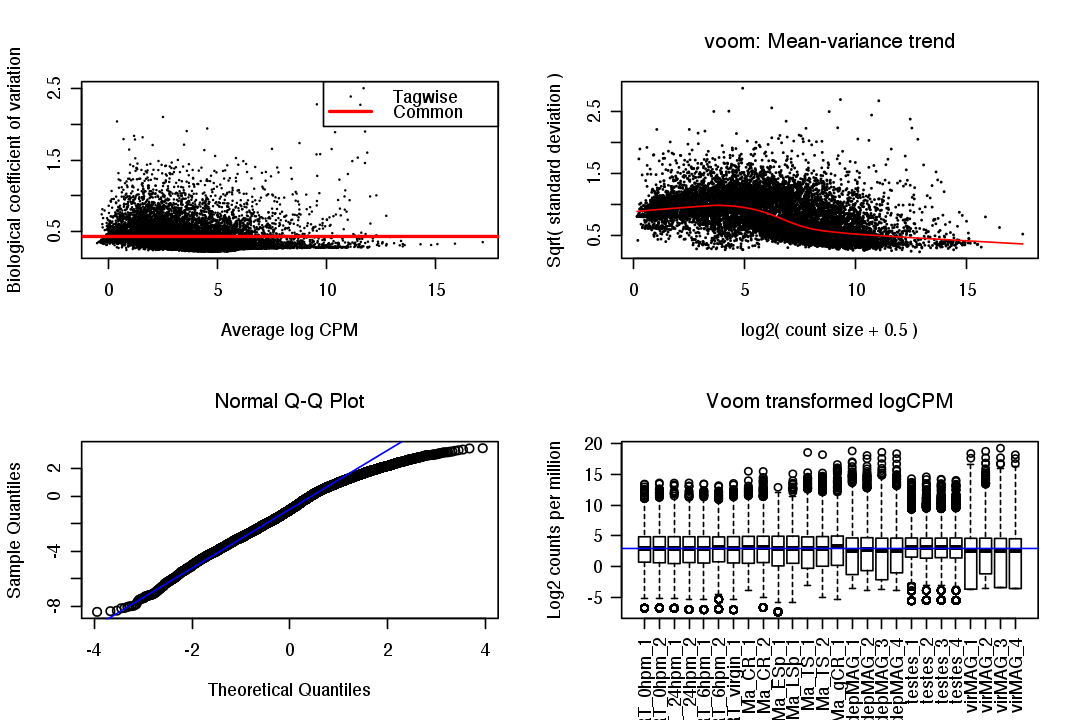

In [31]:
options(repr.plot.width = 9, repr.plot.height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(dgeList)
# mean-variance trend
voomC = voom(dgeList, design, plot=TRUE)
# QQ-plot
g <- gof(dgeList_fit)
z <- zscoreGamma(g$gof.statistics,shape=g$df/2,scale=2)
qqnorm(z); qqline(z, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(voomC$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCPM")
abline(h=median(voomC$E),col="blue")

An interactive MDS plot gives an idea of how replicates/samples are grouping:

In [32]:
glMDSPlot(dgeList, groups = dgeList$samples$group, labels = sampleData$Tissue)

... or a static plot works too:

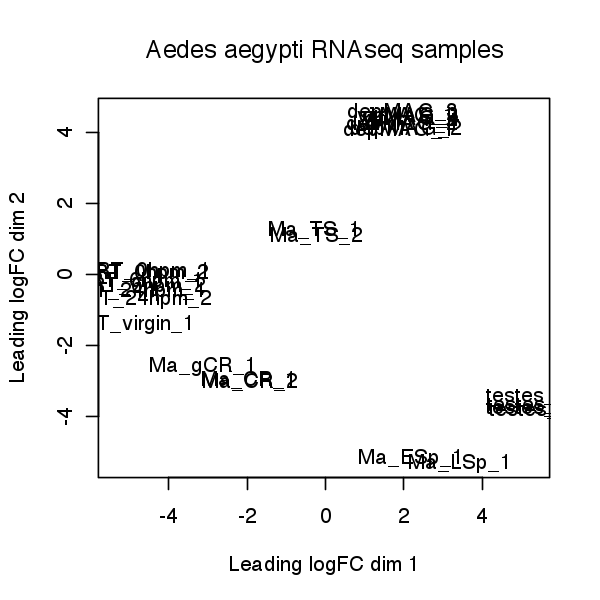

In [33]:
options(repr.plot.width = 5, repr.plot.height = 5)
plotMDS(dgeList)
title("Aedes aegypti RNAseq samples")

##### A heatmap of sample correlations is also useful

for plotting:: min.raw: 0.0808748122648092 max.raw: 1


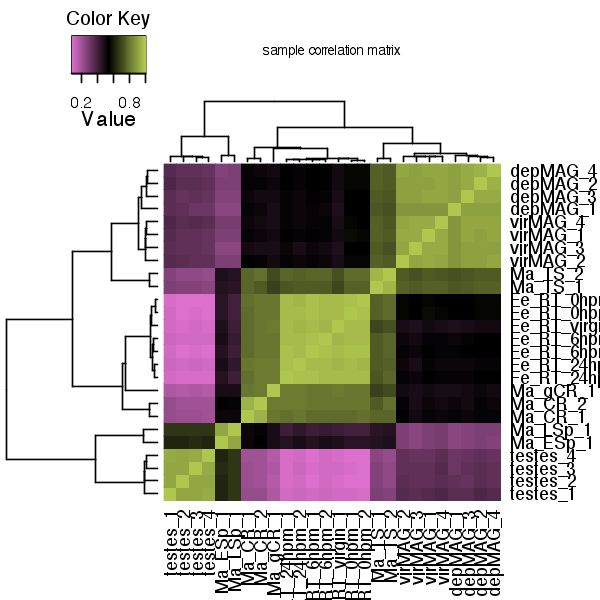

In [34]:
data = log2(counts.keep+1)
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')

options(repr.plot.width = 5, repr.plot.height = 5)
heatmap.3(sample_cor, dendrogram='both', Rowv=as.dendrogram(hc_samples), Colv=as.dendrogram(hc_samples), col = colorpanel(75, '#dd70cd','black','#afc64f'), scale='none', symm=TRUE, key=TRUE,density.info='none', trace='none', symkey=FALSE, symbreaks=F, cexCol=1, cexRow=1, cex.main=0.75, main=paste("sample correlation matrix"))

Now we're ready to define the contrasts. For the three DE tests to be performed, the following contrasts can be defined:

In [35]:
testes.v.rest <- makeContrasts(testes.v.gCR=testes-Ma_gCR,
                                 testes.v.MAG=testes-virMAG,
                                 testes.vs.fRT=testes-Fe_RT_virgin,
                                 levels=design)
MAG.v.rest <- makeContrasts(MAG.v.gCR=virMAG-Ma_gCR,
                                 MAG.v.testes=virMAG-testes,
                                 MAG.vs.fRT=virMAG-Fe_RT_virgin,
                                 levels=design)
fRT.v.rest <- makeContrasts(fRT.v.Ma_CR=Fe_RT_virgin-Ma_CR,
                            fRT.v.testes=Fe_RT_virgin-testes,
                            fRT.v.MAG=Fe_RT_virgin-virMAG,
                            levels=design)

##### Testes-biased genes:

To identify those genes, we'll perform a likelihood ratio test on the GLM fir object that compares the testes sample to the gonadectomized carcass sample, the MAG sample, and the virgin female RT sample. We'll then define testes-biased genes as those showing ≥4-fold increase in expression relative to the other tissues, with an FDR < 0.001.

In [36]:
lrt.testes <- glmLRT(dgeList_fit, contrast = testes.v.rest)

lrt.testes.tTags <- topTags(lrt.testes, n = NULL)
lrt.testes.tTags.table <- lrt.testes.tTags$table
testes.list<-subset(lrt.testes.tTags.table, logFC.testes.v.gCR > 1 & logFC.testes.v.MAG > 1 & logFC.testes.vs.fRT > 1 & FDR<0.05)$GeneID
testes.CDS.list = unique(subset(gene.features, gene_id %in% testes.list & ref_gene_id != "NA")$gene_id)
paste("The number of gene transcripts with testis-biased expression is: ", length(testes.list), ", of which ", length(testes.CDS.list), " are annotated.", sep="")

[1] "The number of gene transcripts with testis-biased expression is: 3013, of which 1928 are annotated."

##### MAG-biased genes

In [37]:
lrt.MAG <- glmLRT(dgeList_fit, contrast = MAG.v.rest)

lrt.MAG.tTags <- topTags(lrt.MAG, n = NULL)
lrt.MAG.tTags.table <- lrt.MAG.tTags$table
MAG.list<-subset(lrt.MAG.tTags.table, logFC.MAG.v.gCR > 1 & logFC.MAG.v.testes > 1 & logFC.MAG.vs.fRT > 1 & FDR<0.05)$GeneID
MAG.CDS.list = unique(subset(gene.features, gene_id %in% MAG.list & ref_gene_id != "NA")$gene_id)
paste("The number of gene transcripts with MAG-biased expression is: ", length(MAG.list), ", of which ", length(MAG.CDS.list), " are annotated protein coding genes.", sep="")

[1] "The number of gene transcripts with MAG-biased expression is: 1237, of which 711 are annotated protein coding genes."

##### fRT-biased genes

In [38]:
lrt.fRT <- glmLRT(dgeList_fit, contrast = fRT.v.rest)

lrt.fRT.tTags <- topTags(lrt.fRT, n = NULL)
lrt.fRT.tTags.table <- lrt.fRT.tTags$table
fRT.list<-subset(lrt.fRT.tTags.table, logFC.fRT.v.Ma_CR > 1 & logFC.fRT.v.testes > 1 & logFC.fRT.v.MAG > 1 & FDR<0.05)$GeneID
fRT.CDS.list = unique(subset(gene.features, gene_id %in% fRT.list & ref_gene_id != "NA")$gene_id)
paste("The number of gene transcripts with fRT-biased expression is: ", length(fRT.list), ", of which ", length(fRT.CDS.list), " are annotated protein coding genes.", sep="")

[1] "The number of gene transcripts with fRT-biased expression is: 1106, of which 919 are annotated protein coding genes."

Now we'll create a factor labeling table for tissue-biasd genes:

In [40]:
MAG_factors = as.data.frame(MAG.list)
MAG_factors$V1 = "MAG-biased"
rownames(MAG_factors) = MAG.list
MAG_factors = subset(MAG_factors, select = "V1")

testes_factors = as.data.frame(testes.list)
testes_factors$V1 = "testes-biased"
rownames(testes_factors) = testes.list
testes_factors = subset(testes_factors, select = "V1")

fRT_factors = as.data.frame(fRT.list)
fRT_factors$V1 = "fRT-biased"
rownames(fRT_factors) = fRT.list
fRT_factors = subset(fRT_factors, select = "V1")

factor.labeling = rbind(MAG_factors, testes_factors, fRT_factors)
colnames(factor.labeling) = c('tissue_bias')
factor_list = unique(factor.labeling[,1])

In [41]:
factor.labeling$tissue_bias = factor(factor.labeling$tissue_bias, levels = c("fRT-biased", "MAG-biased", "testes-biased"))

Subset the CPM/TPM matrix by tissue-biased genes only:

In [42]:
tissueBiased.meanCPM = subset(meanCPMmatrix, rownames(meanCPMmatrix) %in% rownames(factor.labeling))
tissueBiased.meanTPM = subset(meanTPMmatrix, rownames(meanTPMmatrix) %in% rownames(factor.labeling))

Create the heatmap object for plotting:

In [43]:
data = tissueBiased.meanCPM
gene_factors = unique(factor.labeling[,1])
gene_factor_colors = rainbow(length(gene_factors))
names(gene_factor_colors) = gene_factors
data = log2(data+1)
data = as.matrix(data) # convert to matrix
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
myheatcol = colorpanel(75, '#f8e95a','black','#e1526d')
data = t(scale(t(data), scale=F)) # center rows, mean substracted
heatmap_data = data
gene_factor_row_vals = as.factor(factor.labeling[rownames(heatmap_data),])
names(gene_factor_row_vals) = rownames(heatmap_data)
gene_factors_here = unique(gene_factor_row_vals)
names(gene_factors_here) = gene_factors_here
num_gene_factors_here = length(gene_factors_here)
geneFactorColors = c("#9e6ebd",
"#7aa457",
"#cb6751")
geneFactorAnnotations = matrix(nrow=nrow(heatmap_data), ncol=num_gene_factors_here)
for (i in 1:num_gene_factors_here) {
    geneFactorAnnotations[,i] = gene_factor_row_vals %in% gene_factors_here[i]
}
geneFactorAnnotations = apply(geneFactorAnnotations, 1:2, function(x) as.logical(x))
geneFactorAnnotations = t(sample_matrix_to_color_assignments(t(geneFactorAnnotations), col=geneFactorColors))
rownames(geneFactorAnnotations) = rownames(heatmap_data)
colnames(geneFactorAnnotations) = gene_factors_here
heatmap_data[heatmap_data < -1] = -1
heatmap_data[heatmap_data > 1] = 1

for plotting:: min.raw: -1 max.raw: 1


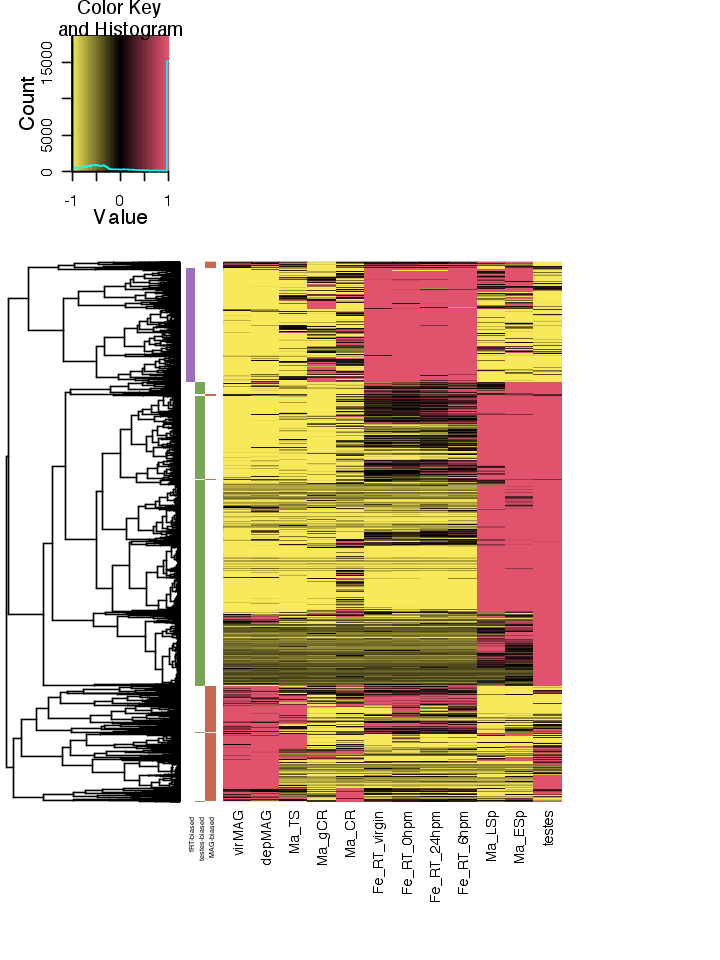

In [44]:
options(repr.plot.width = 6, repr.plot.height = 8)
heatmap.3(heatmap_data, dendrogram = "row", Rowv=as.dendrogram(hc_genes), ,col=myheatcol, RowSideColors=geneFactorAnnotations, scale="none", density.info="histogram", trace="none", key=TRUE, cexCol=1, margins=c(10,10), cexRow=0.5, labRow = F)

### GO analysis:

For GO enrichment analysis, we need to set the gene names to VectorBase IDs:

In [45]:
MAG.VB_IDs.list = unique(subset(gene.features, gene_id %in% MAG.list & ref_gene_id != "NA")$ref_gene_id)
testes.VB_IDs.list = unique(subset(gene.features, gene_id %in% testes.list & ref_gene_id != "NA")$ref_gene_id)
fRT.VB_IDs.list = unique(subset(gene.features, gene_id %in% fRT.list & ref_gene_id != "NA")$ref_gene_id)

MAG_vb_factors = as.data.frame(MAG.VB_IDs.list)
MAG_vb_factors$V1 = "MAG-biased"
rownames(MAG_vb_factors) = MAG.VB_IDs.list
MAG_vb_factors = subset(MAG_vb_factors, select = "V1")

testes_vb_factors = as.data.frame(testes.VB_IDs.list)
testes_vb_factors$V1 = "testes-biased"
rownames(testes_vb_factors) = testes.VB_IDs.list
testes_vb_factors = subset(testes_vb_factors, select = "V1")

fRT_vb_factors = as.data.frame(fRT.VB_IDs.list)
fRT_vb_factors$V1 = "fRT-biased"
rownames(fRT_vb_factors) = fRT.VB_IDs.list
fRT_vb_factors = subset(fRT_vb_factors, select = "V1")

vb.factor.labeling = rbind(MAG_vb_factors, testes_vb_factors, fRT_vb_factors)
colnames(vb.factor.labeling) = c('tissue_bias')
vb_factor_list = unique(vb.factor.labeling[,1])

In [46]:
tmpData = unique(subset(gene.features, select = c("gene_id", "ref_gene_id")))
tmpData = unique(merge(tmpData, gene_lengths, by.x = "gene_id", by.y = "gene_id"))
vb_gene_lengths = subset(tmpData, ref_gene_id != "NA")
vb_gene_lengths = subset(vb_gene_lengths, select = c("ref_gene_id", "length"))
colnames(vb_gene_lengths) = c("vb_ID", "length")
vb_gene_lengths <- vb_gene_lengths[order(vb_gene_lengths$vb_ID),]
# vb_gene_lengths = as.matrix(vb_gene_lengths)
rownames(vb_gene_lengths) <- vb_gene_lengths$vb_ID
vb_gene_lengths[,1] <- NULL

Load the GO info here:

In [47]:
GO_info_listed = apply(GO_info, 1, function(x) unlist(strsplit(x,',')))
names(GO_info_listed) = rownames(GO_info)
features_with_GO = rownames(GO_info)
lengths_features_with_GO = vb_gene_lengths[features_with_GO,]
get_GO_term_descr =  function(x) {
    d = 'none';
    go_info = GOTERM[[x]];
    if (length(go_info) >0) { d = paste(Ontology(go_info), Term(go_info), sep=' ');}
    return(d);
}

In [48]:
# build pwf based on ALL DE features
options(repr.plot.width = 6, repr.plot.height = 3)

cat_genes_vec = as.integer(features_with_GO %in% rownames(vb.factor.labeling))

Warning message in pcls(G):
"initial point very close to some inequality constraints"

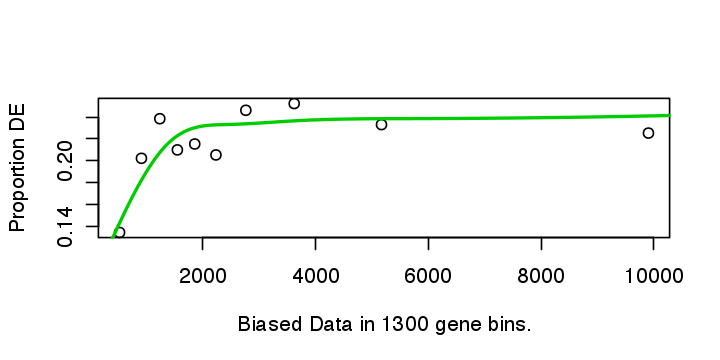

In [49]:
pwf=nullp(cat_genes_vec,bias.data=lengths_features_with_GO)
rownames(pwf) = names(GO_info_listed)

In [50]:
GO_enriched_list = list()

for (feature_cat in vb_factor_list) {
    message('Processing category: ', feature_cat)
    cat_genes_vec = as.integer(features_with_GO %in% rownames(vb.factor.labeling)[vb.factor.labeling$tissue_bias == feature_cat])
    pwf$DEgenes = cat_genes_vec
    res = goseq(pwf,gene2cat=GO_info_listed)
    ## over-represented categories:
    pvals = res$over_represented_pvalue
    pvals[pvals > 1 -1e-10] = 1-1e-10
    q = qvalue(pvals)
    res$over_represented_FDR = q$qvalues
    go_enrich_factor = feature_cat
    enrich_result_table = res[res$over_represented_pvalue<=0.05,]
    descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
    enrich_result_table$go_term = descr
    enrich_result_table$factor = go_enrich_factor
    GO_enriched_list[[feature_cat]] = enrich_result_table
}

GO_enrichment_data = rbindlist(GO_enriched_list)

Processing category: MAG-biased
Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns
Processing category: testes-biased
Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns
Processing category: fRT-biased
Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.
Warning message:
"Removed 15 rows containing missing values (geom_point)."Warning message:
"Removed 15 rows containing missing values (geom_text_repel)."

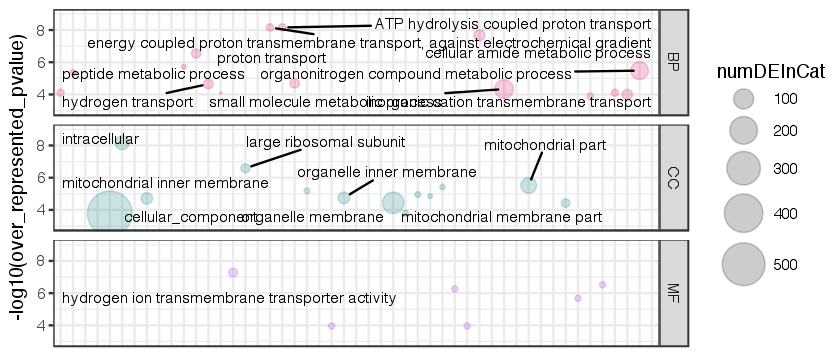

In [51]:
### RT plot
options(repr.plot.width = 7, repr.plot.height = 3)
#pdf("RT-biased.GO.pdf", width = 8.10, height = 3)
ggplot(subset(GO_enrichment_data, over_represented_FDR < 0.05 & factor == "MAG-biased"), 
       aes(category, -log10(over_represented_pvalue), size = numDEInCat, colour = ontology)) + 
    geom_point(alpha = 0.2)  + 
    facet_grid(ontology~.) +
    xlab(NULL) + 
    geom_text_repel(data = subset(GO_enrichment_data, over_represented_FDR < 0.05 & factor == "MAG-biased" & numDEInCat > 10), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 12, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) +  
    scale_size(range=c(-3,8)) +
    theme_bw() +
    theme(axis.text.x = element_blank(), axis.ticks.x = element_blank()) + 
    scale_size(range = c(0,12)) + 
    scale_colour_manual(values=c("#e00068",
                                 "#01777b",
                                 "#9d31e4")) +
    guides(colour = FALSE) +
    scale_y_continuous(limits=c(3, 9))

Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.
Warning message:
"Removed 72 rows containing missing values (geom_point)."Warning message:
"Removed 26 rows containing missing values (geom_text_repel)."

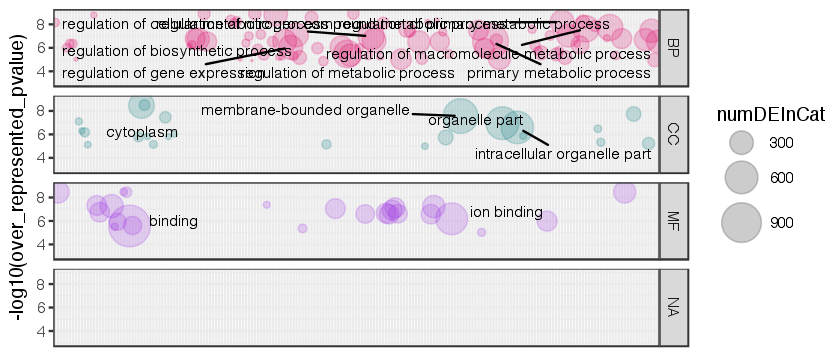

In [52]:
### testes plot
options(repr.plot.width = 7, repr.plot.height = 3)
#pdf("RT-biased.GO.pdf", width = 8.10, height = 3)
ggplot(subset(GO_enrichment_data, over_represented_FDR < 0.001 & factor == "testes-biased"), 
       aes(category, -log10(over_represented_pvalue), size = numDEInCat, colour = ontology)) + 
    geom_point(alpha = 0.2)  + 
    facet_grid(ontology~.) +
    xlab(NULL) + 
    geom_text_repel(data = subset(GO_enrichment_data, over_represented_FDR < 0.001 & factor == "testes-biased" & numDEInCat > 300), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 12, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) +  
    scale_size(range=c(-3,8)) +
    theme_bw() +
    theme(axis.text.x = element_blank(), axis.ticks.x = element_blank()) + 
    scale_size(range = c(0,12)) + 
    scale_colour_manual(values=c("#e00068",
                                 "#01777b",
                                 "#9d31e4")) +
    guides(colour = FALSE) +
    scale_y_continuous(limits=c(3, 9))

Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.
Warning message:
"Removed 15 rows containing missing values (geom_point)."Warning message:
"Removed 8 rows containing missing values (geom_text_repel)."

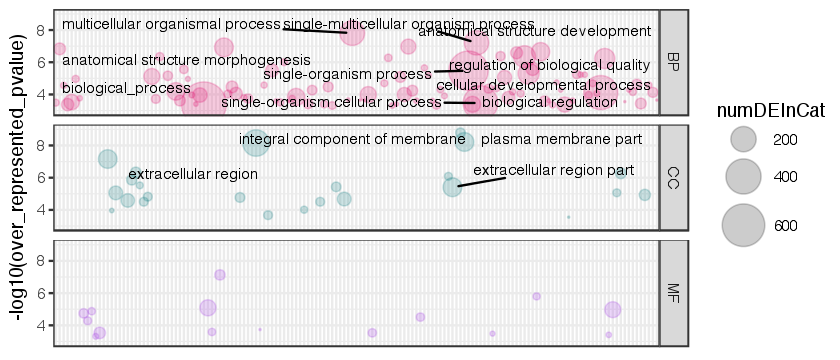

In [53]:
### fRT plot
options(repr.plot.width = 7, repr.plot.height = 3)
#pdf("RT-biased.GO.pdf", width = 8.10, height = 3)
ggplot(subset(GO_enrichment_data, over_represented_FDR < 0.05 & factor == "fRT-biased"), 
       aes(category, -log10(over_represented_pvalue), size = numDEInCat, colour = ontology)) + 
    geom_point(alpha = 0.2)  + 
    facet_grid(ontology~.) +
    xlab(NULL) + 
    geom_text_repel(data = subset(GO_enrichment_data, over_represented_FDR < 0.05 & factor == "fRT-biased" & numDEInCat > 100), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 12, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) +  
    scale_size(range=c(-3,8)) +
    theme_bw() +
    theme(axis.text.x = element_blank(), axis.ticks.x = element_blank()) + 
    scale_size(range = c(0,12)) + 
    scale_colour_manual(values=c("#e00068",
                                 "#01777b",
                                 "#9d31e4")) +
    guides(colour = FALSE) +
    scale_y_continuous(limits=c(3, 9))

## DE analysis with just Ethan's data:

In [54]:
e.groups = factor(subset(sampleData, Source == "Degner")$Sample)
e.design = model.matrix( ~ 0 + e.groups)
colnames(e.design) <- levels(e.groups)
rownames(e.design) <- subset(sampleData, Source == "Degner")$Replicate

Now we'll create the edgeR DGE object with these groupings and fit the genelized linear model. First we'll subset the count matrix to include Ethan's data only:

In [55]:
# Now filter this subsetted count matrix:
e.CPM <- cpm(ethan.countsMatrix)
e.thresh <- e.CPM > 5
e.keep <- rowSums(e.thresh) >= 4
e.counts.keep <- ethan.countsMatrix[e.keep,]
nrow(e.counts.keep)

[1] 9417

In [56]:
e.dgeList <- DGEList(counts = e.counts.keep, group = e.groups)
e.dgeList <- calcNormFactors(e.dgeList)
e.dgeList <- estimateCommonDisp(e.dgeList)
e.dgeList <- estimateTagwiseDisp(e.dgeList)
e.dgeList_fit <- glmFit(e.dgeList, e.design)

Add annotation information:

In [57]:
# Extract annotation for genes in the fit object
ann.e = subset(annots, mstrg_ID %in% rownames(e.dgeList_fit))
# convert factors to characters
ann.e = data.frame(lapply(ann.e, as.character), stringsAsFactors=FALSE)
# align the fit object's rownames with gene ID's
ann.e = ann.e[match(rownames(e.dgeList_fit), ann.e$mstrg_ID),]
# convert factors to characters, again
ann.e <- data.frame(lapply(ann.e, as.character), stringsAsFactors=FALSE)
# Rename "FBgn_ID" as "GeneID"
colnames(ann.e) = c ("GeneID", "VB_ID", "gene_name","Description")
# Check that the fit rownames match the annotation file's gene ID's
table(ann.e$GeneID==rownames(e.dgeList_fit))
# Add the annotations to the fit object in the "genes" slot
e.dgeList_fit$genes = ann.e


TRUE 
9417 

We can look at the variability by examining the tagwise dispersion:

In [58]:
summary(e.dgeList$tagwise.dispersion)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.04987 0.09280 0.11560 0.19420 0.17880 3.64000 

We can take a closer look at the DE materics and whether overall variability in the counts is suitable by plotting the BCV, looking at the mean-variance trend and QQplot:

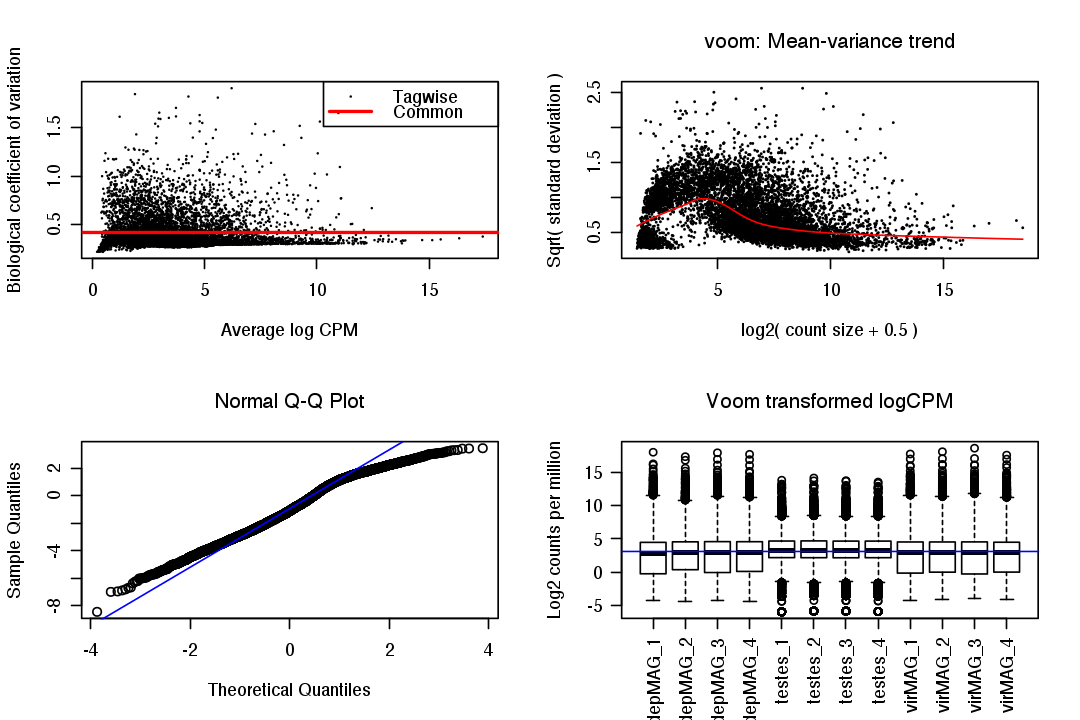

In [59]:
options(repr.plot.width = 9, repr.plot.height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(e.dgeList)
# mean-variance trend
voomC = voom(e.dgeList, e.design, plot=TRUE)
# QQ-plot
g <- gof(e.dgeList_fit)
z <- zscoreGamma(g$gof.statistics,shape=g$df/2,scale=2)
qqnorm(z); qqline(z, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(voomC$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCPM")
abline(h=median(voomC$E),col="blue")

We'll compare the virgin MAG sample with the depleted MAG sample:

In [60]:
vMAG.v.dMAG <- makeContrasts(vMAG.vs.dMAG=virMAG-depMAG,
                             levels=e.design)

lrt.dvMAG <- glmLRT(e.dgeList_fit, contrast = vMAG.v.dMAG)

lrt.dvMAG.tTags <- topTags(lrt.dvMAG, n = NULL)
lrt.dvMAG.tTags.table <- lrt.dvMAG.tTags$table
dvMAG.list<-subset(lrt.dvMAG.tTags.table, logFC < -1 & FDR<0.01 | logFC > 1 & FDR<0.01)$GeneID
dvMAG.CDS.list = unique(subset(gene.features, gene_id %in% dvMAG.list & ref_gene_id != "NA")$gene_id)
paste("The number of gene transcripts the are differentially expressed between virgin and depleted MAGs is ", length(dvMAG.list), ", of which ", length(dvMAG.CDS.list), " are annotated protein coding genes.", sep="")

[1] "The number of gene transcripts the are differentially expressed between virgin and depleted MAGs is 522, of which 446 are annotated protein coding genes."

For volcano plots, we need to run the glmTreat model:

In [61]:
lrt_dMAG.v.vMAG <- glmTreat(e.dgeList_fit, contrast = c(-1,0,1), lfc =1)

Then run the decide test

In [62]:
dt.dvMAG = decideTestsDGE(lrt_dMAG.v.vMAG)

Also subset the data info:

In [63]:
sampleData.e = subset(sampleData, Source == "Degner")

Now make the plot:

In [64]:
glXYPlot(x=lrt_dMAG.v.vMAG$table$logFC, y=-log10(lrt_dMAG.v.vMAG$table$PValue), xlab="logFC", ylab="logodds", status=dt.dvMAG, groups=sampleData.e$Sample, side.main="gene_name", anno = ann.e, counts = e.dgeList)

We'll create a cluster object and generate a heatmap:

In [65]:
MAG_DE.meanCPM = subset(meanCPMmatrix, rownames(meanCPMmatrix) %in% dvMAG.list)
MAG_DE.meanCPM = subset(MAG_DE.meanCPM, select=c("depMAG", "testes", "virMAG"))
MAG_DE.meanTPM = subset(meanTPMmatrix, rownames(meanTPMmatrix) %in% dvMAG.list)
MAG_DE.meanTPM = subset(MAG_DE.meanTPM, select=c("depMAG", "virMAG"))

In [66]:
data = MAG_DE.meanTPM
data = log2(data+1)
data = as.matrix(data) # convert to matrix
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')

myheatcol = colorpanel(75, '#f8e95a','black','#e1526d')
data = t(scale(t(data), scale=F)) # center rows, mean substracted
heatmap_data = data
heatmap_data[heatmap_data < -2] = -2
heatmap_data[heatmap_data > 2] = 2

for plotting:: min.raw: -2 max.raw: 2


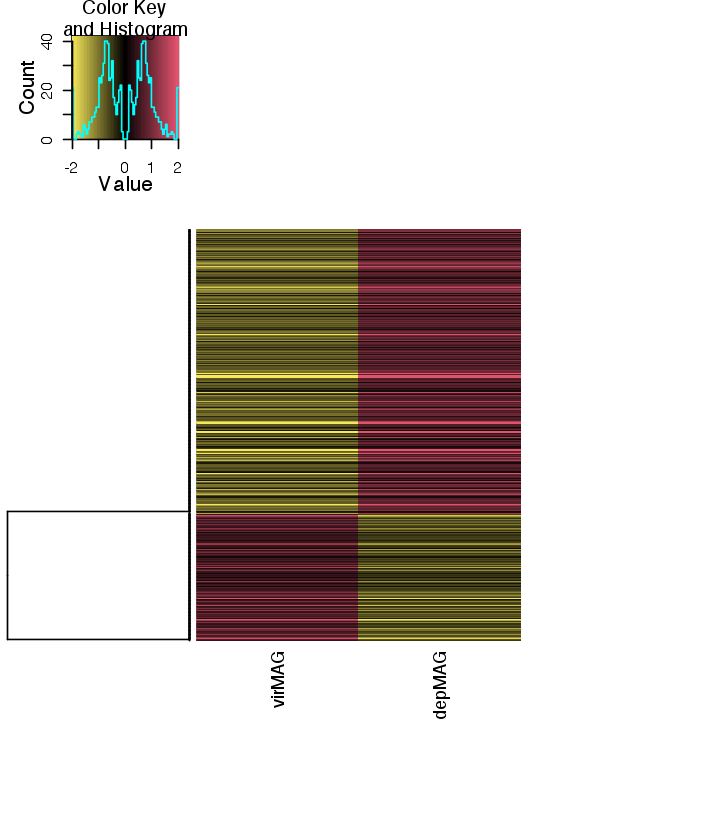

In [67]:
options(repr.plot.width = 6, repr.plot.height = 7)
heatmap.3(heatmap_data, dendrogram = "row", Rowv=as.dendrogram(hc_genes), col=myheatcol, scale="none", density.info="histogram", trace="none", key=TRUE, cexCol=1, margins=c(10,10), cexRow=0.5, labRow = F)

Looks like 2 clusters summarize the variation:

In [68]:
gene_partition_assignments <- cutree(as.hclust(hc_genes), k=2)
partition_colors = rainbow(length(unique(gene_partition_assignments)), start=0.4, end=0.95)
gene_colors_dframe = data.frame(clusters=gene_partition_assignments, colors=partition_colors[gene_partition_assignments])
gene_colors = as.matrix(partition_colors[gene_partition_assignments])

We'll loop over the cluster assignments and import them into the cluster list object:

In [69]:
cluster_list = list()
max_cluster_count = max(gene_partition_assignments)
for (i in 1:max_cluster_count) {
    partition_i = (gene_partition_assignments == i)
    partition_data = data[partition_i,,drop=F]
    cluster_list[[i]] = as.data.frame(partition_data)
    cluster_list[[i]]$Gene_ID = rownames(cluster_list[[i]])
    cluster_list[[i]]$cluster = paste("cluster_", i, sep = "")
}

#cluster_list
cluster_data = rbindlist(cluster_list)

We'll reshape first:

In [70]:
cluster_data.m = melt(cluster_data, id.vars = c("Gene_ID", "cluster"))

Now plot it:

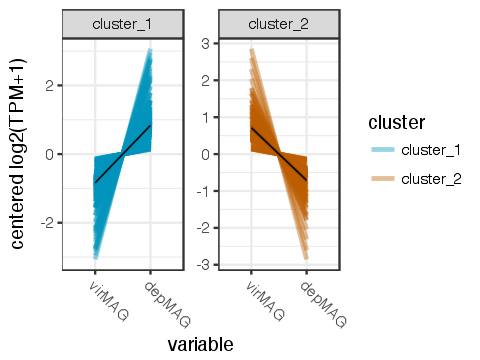

In [71]:
cluster_data.m$cluster = factor(cluster_data.m$cluster, levels = c("cluster_1", "cluster_2"))
cluster_data.m$variable = factor(cluster_data.m$variable, levels = c("virMAG", "depMAG"))
options(repr.plot.width = 4, repr.plot.height = 3)

ggplot(cluster_data.m, aes(variable, value, group= Gene_ID, colour = cluster)) + 
    geom_line(alpha = 0.4,
              size = 1) +
    theme_bw() + 
    facet_wrap('cluster',scales='free_y') +
    scale_color_hue(l=50,h.start=200) + 
    theme(axis.text.x=element_text(angle=-45,hjust=0)) +
    stat_summary(data = cluster_data.m, 
                 aes(x=variable,y=value, group = cluster),
                 fun.data="mean_cl_boot",
                 color="black",
                 fill="black",
                 alpha=0.2,
                 size=0.3,
                 geom="smooth") +
    ylab("centered log2(TPM+1)")

We can look at whether any GO terms are enriched within these two sets:

In [72]:
c1.mstrg.IDs = unique(subset(cluster_data.m, cluster == "cluster_1")$Gene_ID)
c2.mstrg.IDs = unique(subset(cluster_data.m, cluster == "cluster_2")$Gene_ID)

In [73]:
deMAG.up.VB_IDs.list = unique(subset(gene.features, gene_id %in% c1.mstrg.IDs & ref_gene_id != "NA")$ref_gene_id)
deMAG.down.VB_IDs.list = unique(subset(gene.features, gene_id %in% c2.mstrg.IDs & ref_gene_id != "NA")$ref_gene_id)

deMAG.up_vb_factors = as.data.frame(deMAG.up.VB_IDs.list)
deMAG.up_vb_factors$V1 = "Upregulated"
rownames(deMAG.up_vb_factors) = deMAG.up.VB_IDs.list
deMAG.up_vb_factors = subset(deMAG.up_vb_factors, select = "V1")

deMAG.down_vb_factors = as.data.frame(deMAG.down.VB_IDs.list)
deMAG.down_vb_factors$V1 = "Downregulated"
rownames(deMAG.down_vb_factors) = deMAG.down.VB_IDs.list
deMAG.down_vb_factors = subset(deMAG.down_vb_factors, select = "V1")

deMAG.factor.labeling = rbind(deMAG.up_vb_factors, deMAG.down_vb_factors)
colnames(deMAG.factor.labeling) = c('DE_status')
deMAG_factor_list = unique(deMAG.factor.labeling[,1])

Warning message in pcls(G):
"initial point very close to some inequality constraints"

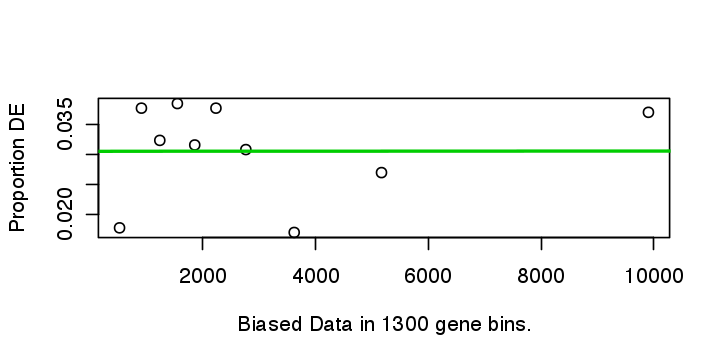

In [74]:
options(repr.plot.width = 6, repr.plot.height = 3)

cat_genes_vec = as.integer(features_with_GO %in% rownames(deMAG.factor.labeling))
pwf=nullp(cat_genes_vec,bias.data=lengths_features_with_GO)
rownames(pwf) = names(GO_info_listed)

In [75]:
GO_enriched_list = list()

for (feature_cat in deMAG_factor_list) {
    message('Processing category: ', feature_cat)
    cat_genes_vec = as.integer(features_with_GO %in% rownames(deMAG.factor.labeling)[deMAG.factor.labeling$DE_status == feature_cat])
    pwf$DEgenes = cat_genes_vec
    res = goseq(pwf,gene2cat=GO_info_listed)
    ## over-represented categories:
    pvals = res$over_represented_pvalue
    pvals[pvals > 1 -1e-10] = 1-1e-10
    q = qvalue(pvals)
    res$over_represented_FDR = q$qvalues
    go_enrich_factor = feature_cat
    enrich_result_table = res[res$over_represented_pvalue<=0.05,]
    descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
    enrich_result_table$go_term = descr
    enrich_result_table$factor = go_enrich_factor
    GO_enriched_list[[feature_cat]] = enrich_result_table
}

GO_enrichment_data = rbindlist(GO_enriched_list)

Processing category: Upregulated
Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns
Processing category: Downregulated
Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


Warning message:
"Removed 4 rows containing missing values (geom_point)."Warning message:
"Removed 2 rows containing missing values (geom_text_repel)."

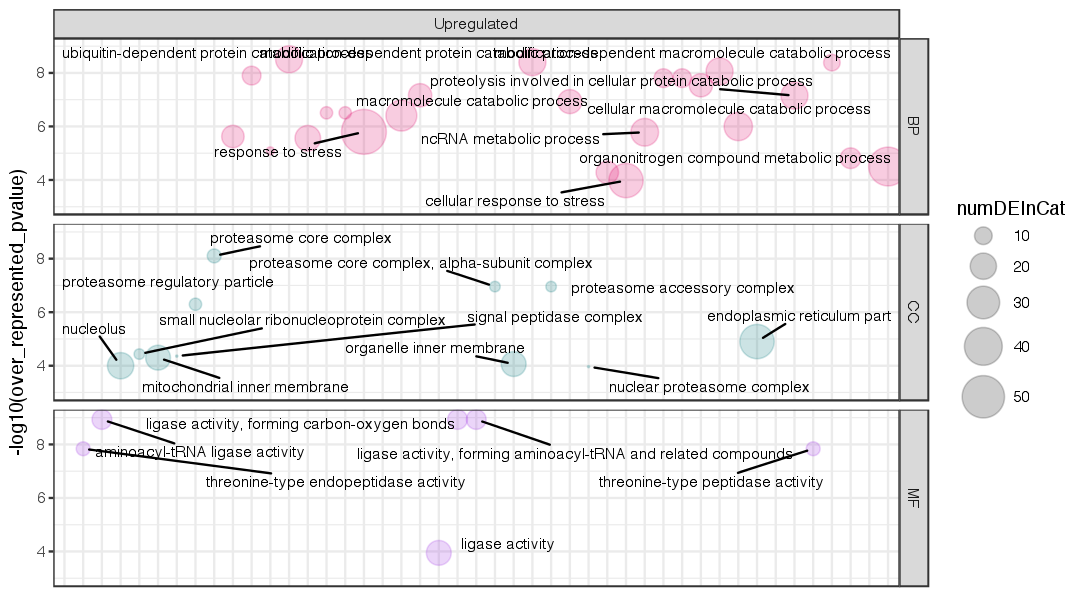

In [76]:
options(repr.plot.width = 9, repr.plot.height = 5)
ggplot(subset(GO_enrichment_data, over_represented_FDR < 0.05), 
       aes(category, -log10(over_represented_pvalue), size = numDEInCat, colour = ontology)) + 
    geom_point(alpha = 0.2)  + 
    facet_grid(ontology~factor) +
    xlab(NULL) + 
    geom_text_repel(data = subset(GO_enrichment_data, over_represented_FDR < 0.05 & numDEInCat > 20 & ontology == "BP"), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 30, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) + 
    geom_text_repel(data = subset(GO_enrichment_data, over_represented_FDR < 0.05 & ontology == "CC"), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 30, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) + 
    geom_text_repel(data = subset(GO_enrichment_data, over_represented_FDR < 0.05 & ontology == "MF"), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 30, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) + 
#     scale_size(range=c(-3,8)) +
    theme_bw() +
    theme(axis.text.x = element_blank(), axis.ticks.x = element_blank()) + 
    scale_size(range = c(0,12)) + 
    scale_colour_manual(values=c("#e00068",
                                 "#01777b",
                                 "#9d31e4")) +
    guides(colour = FALSE) +
    scale_y_continuous(limits=c(3, 9))

## Proteome data

Load the final proteomics data file:

In [77]:
proteome_data = read.csv("proteomics/complete_result.txt", header = T, sep = "\t")

Combine the IDs from the new annotation with the NCBI annotation and MSTRG IDs:

In [78]:
tmpFile = unique(subset(geneFeatures, loc_ID %in% proteome_data$gene))
proteome_IDs = unique(subset(tmpFile, select = c("mstrg_ID", "gene_ID", "loc_ID", "gene_name")))
ejaculotome = merge(proteome_IDs, proteome_data, by.x = "loc_ID", by.y = "gene", all = TRUE)

Load the protein abundance data

In [79]:
apex = read.csv("proteomics/APEX_semen_v_sperm_longest_full_comb_comet.txt", header = T, sep = "\t")

Also load the Sirot 2011 data:

In [80]:
sirot = read.csv("annotation/sirot/Sirot_combined_SFP_and_sperm.txt", header = T, sep = "\t")
sirot_SFPs = subset(sirot, Class == "SFP" & L5_geneID != "NA")$L5_geneID
sirot_Sps = subset(sirot, Class == "Sperm" & L5_geneID != "NA")$L5_geneID

First we'll check the overlap of protein IDs across the three search algorithms:

In [81]:
sperm.combined.full = subset(proteome_data, sperm.combined.full == 1)$gene
sperm.tandem.full = subset(proteome_data, sperm.tandem.full == 1)$gene
sperm.comet.full = subset(proteome_data, sperm.comet.full == 1)$gene

and semen samples:

In [82]:
semen.combined.full = subset(proteome_data, semen.combined.full == 1)$gene
semen.tandem.full = subset(proteome_data, semen.tandem.full == 1)$gene
semen.comet.full = subset(proteome_data, semen.comet.full == 1)$gene

We'll also extract the gene IDs used for expression analysis:

In [83]:
sirot_SFPs_mstrg = unique(subset(ref_to_gene, loc_ID %in% sirot_SFPs & !is.na(mstrg_ID))$mstrg_ID)
sirot_Sps_mstrg = unique(subset(ref_to_gene, loc_ID %in% sirot_Sps & !is.na(mstrg_ID))$mstrg_ID)
sperm.combined.full_mstrg = unique(subset(ref_to_gene, loc_ID %in% sperm.combined.full & !is.na(mstrg_ID))$mstrg_ID)
sperm.tandem.full_mstrg = unique(subset(ref_to_gene, loc_ID %in% sperm.tandem.full & !is.na(mstrg_ID))$mstrg_ID)
sperm.comet.full_mstrg = unique(subset(ref_to_gene, loc_ID %in% sperm.comet.full & !is.na(mstrg_ID))$mstrg_ID)
semen.combined.full_mstrg = unique(subset(ref_to_gene, loc_ID %in% semen.combined.full & !is.na(mstrg_ID))$mstrg_ID)
semen.tandem.full_mstrg = unique(subset(ref_to_gene, loc_ID %in% semen.tandem.full & !is.na(mstrg_ID))$mstrg_ID)
semen.comet.full_mstrg = unique(subset(ref_to_gene, loc_ID %in% semen.comet.full & !is.na(mstrg_ID))$mstrg_ID)

We can distribute those across a list object and create a  venn diagram object:

In [84]:
sperm_candidates <- list(combined = sperm.combined.full, tandem = sperm.tandem.full, comet = sperm.comet.full, sirot = sirot_Sps)

sperm_combs <- unlist(lapply(1:length(sperm_candidates), function(j) combn(names(sperm_candidates), j, simplify = FALSE)), recursive = FALSE)
    
names(sperm_combs) <- sapply(sperm_combs, function(i) paste0(i, collapse = ","))
    
sperm_elements <- lapply(sperm_combs, function(i) Setdiff(sperm_candidates[i], sperm_candidates[setdiff(names(sperm_candidates), i)]))
    
sperm_Vdiag<-venn.diagram(sperm_candidates, NULL, fill=c("#8d2878","#95d864","#ff3ea8", "gray"), alpha=c(0.75, 0.75,0.75, 0.75), cex = 1, cat.fontface= 2, cat.cex = 1, resolution = 1000, main = "sperm proteome")

Same for semen proteins:

In [85]:
semen_candidates <- list(combined = semen.combined.full, tandem = semen.tandem.full, comet = semen.comet.full, sirot = sirot_SFPs)

semen_combs <- unlist(lapply(1:length(semen_candidates), function(j) combn(names(semen_candidates), j, simplify = FALSE)), recursive = FALSE)
    
names(semen_combs) <- sapply(semen_combs, function(i) paste0(i, collapse = ","))
    
semen_elements <- lapply(semen_combs, function(i) Setdiff(semen_candidates[i], semen_candidates[setdiff(names(semen_candidates), i)]))
    
semen_Vdiag<-venn.diagram(semen_candidates, NULL, fill=c("#8d2878","#95d864","#ff3ea8", "gray"), alpha=c(0.75, 0.75,0.75, 0.75), cex = 1, cat.fontface= 2, cat.cex = 1, resolution = 1000, main = "semen proteome")

Now we can plot the two venn diagrams:

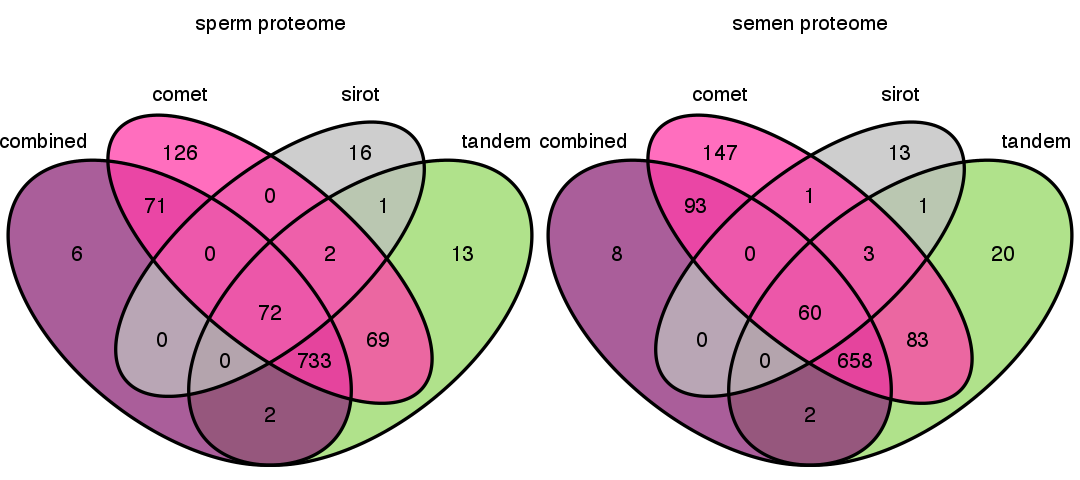

In [86]:
options(repr.plot.width = 9, repr.plot.height = 4)
grid.arrange(gTree(children=sperm_Vdiag), gTree(children=semen_Vdiag), ncol = 2)

Lets do the same for MSTRG Id's, but remove Sirot data, so we can look at mRNA expressions profile:

In [87]:
sperm_candidates_mstrg <- list(combined = sperm.combined.full_mstrg, tandem = sperm.tandem.full_mstrg, comet = sperm.comet.full_mstrg)
sperm_combs_mstrg <- unlist(lapply(1:length(sperm_candidates_mstrg), function(j) combn(names(sperm_candidates_mstrg), j, simplify = FALSE)), recursive = FALSE)
names(sperm_combs_mstrg) <- sapply(sperm_combs_mstrg, function(i) paste0(i, collapse = ","))
sperm_elements_mstrg <- lapply(sperm_combs_mstrg, function(i) Setdiff(sperm_candidates_mstrg[i], sperm_candidates_mstrg[setdiff(names(sperm_candidates_mstrg), i)]))
sperm_Vdiag_mstrg<-venn.diagram(sperm_candidates_mstrg, NULL, fill=c("#b8c80c","#5c3ea8","#d3003b"), alpha=c(0.75,0.75,0.75), cex = 1, cat.fontface= 2, cat.cex = 1, resolution = 1000, main = "sperm proteome") 

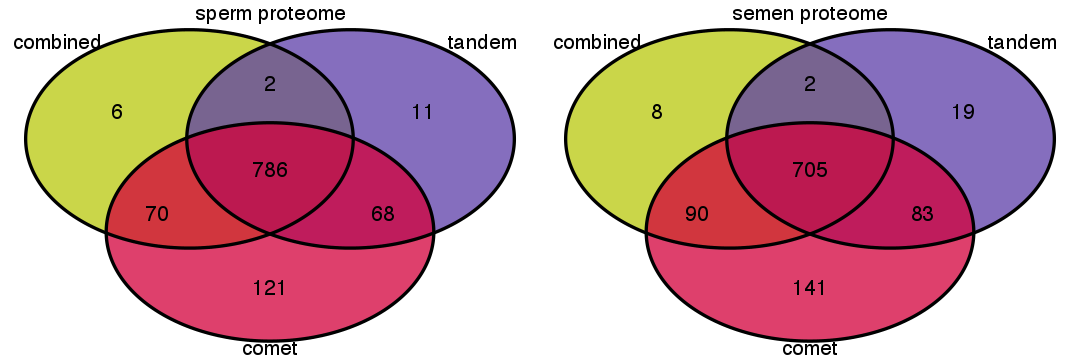

In [88]:
semen_candidates_mstrg <- list(combined = semen.combined.full_mstrg, tandem = semen.tandem.full_mstrg, comet = semen.comet.full_mstrg)
semen_combs_mstrg <- unlist(lapply(1:length(semen_candidates_mstrg), function(j) combn(names(semen_candidates_mstrg), j, simplify = FALSE)), recursive = FALSE)
names(semen_combs_mstrg) <- sapply(semen_combs_mstrg, function(i) paste0(i, collapse = ","))
semen_elements_mstrg <- lapply(semen_combs_mstrg, function(i) Setdiff(semen_candidates_mstrg[i], semen_candidates_mstrg[setdiff(names(semen_candidates_mstrg), i)]))
semen_Vdiag_mstrg<-venn.diagram(semen_candidates_mstrg, NULL, fill=c("#b8c80c","#5c3ea8","#d3003b"), alpha=c(0.75,0.75,0.75), cex = 1, cat.fontface= 2, cat.cex = 1, resolution = 1000, main = "semen proteome")
    
options(repr.plot.width = 9, repr.plot.height = 3)
grid.arrange(gTree(children=sperm_Vdiag_mstrg), gTree(children=semen_Vdiag_mstrg), ncol = 2)

Now let's look at the overlap between union of sperm and semen proteins against the full genome search:

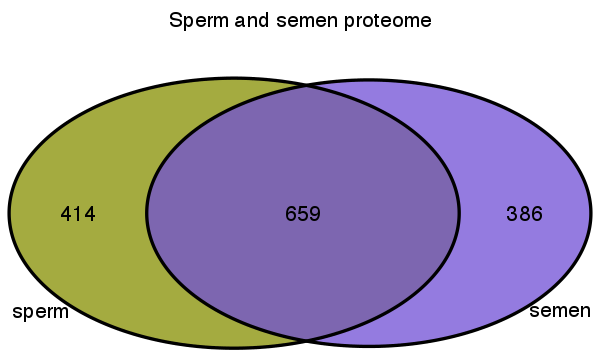

In [89]:
semen.union.full = subset(proteome_data, semen.comet.full == 1)$gene
sperm.union.full = subset(proteome_data, sperm.comet.full == 1)$gene

ejaculotome <- list(semen = semen.union.full, sperm = sperm.union.full)
ejaculotome_combs <- unlist(lapply(1:length(ejaculotome), function(j) combn(names(ejaculotome), j, simplify = FALSE)), recursive = FALSE)
names(ejaculotome_combs) <- sapply(ejaculotome_combs, function(i) paste0(i, collapse = ","))
ejaculotome_elements <- lapply(ejaculotome_combs, function(i) Setdiff(ejaculotome[i], ejaculotome[setdiff(names(ejaculotome), i)]))
ejaculotome_Vdiag<-venn.diagram(ejaculotome, NULL, fill=c("#704fd6","#868f00"), alpha=c(0.75,0.75), cex = 1, cat.fontface= 2, cat.cex = 1, resolution = 1000, main = "Sperm and semen proteome")
    
options(repr.plot.width = 5, repr.plot.height = 3)
grid.arrange(gTree(children=ejaculotome_Vdiag))

To plot heatmaps and map-on algorithm as genes factor, must face specify a factor table. For sperm:

In [90]:
sperm_elements_factor_df = as.data.frame(unlist(sperm_elements_mstrg))
sperm_elements_factor_df$method = gsub('[[:digit:]]+', '', rownames(sperm_elements_factor_df))
sperm_elements_factor_df = as.data.frame(as.list(sperm_elements_factor_df))
rownames(sperm_elements_factor_df) = sperm_elements_factor_df$unlist.sperm_elements_mstrg.
sperm_elements_factor_df = subset(sperm_elements_factor_df, select = "method")

And for semen

In [91]:
semen_elements_factor_df = as.data.frame(unlist(semen_elements_mstrg))
semen_elements_factor_df$method = gsub('[[:digit:]]+', '', rownames(semen_elements_factor_df))
semen_elements_factor_df = as.data.frame(as.list(semen_elements_factor_df))
rownames(semen_elements_factor_df) = semen_elements_factor_df$unlist.semen_elements_mstrg.
semen_elements_factor_df = subset(semen_elements_factor_df, select = "method")

Now we'll extra TPM matrices for each group

Here we can look at the correlation between protein abundance and RNA expression:

In [93]:
tmpIDs = subset(ref_to_gene, loc_ID %in% apex$ACC)
tmpIDs = unique(subset(tmpIDs, select = c("mstrg_ID", "gene_ID", "loc_ID")))
proteome_TPM = subset(meanTPMmatrix, rownames(meanTPMmatrix) %in% tmpIDs$mstrg_ID)
proteome_TPM$gene_id = rownames(proteome_TPM)
tmpThing = merge(proteome_TPM, tmpIDs, by.x = "gene_id", by.y = "mstrg_ID")
apex_RNAseq = merge(tmpThing, apex, by.x = "loc_ID", by.y = "ACC")

Warning message:
"Removed 396 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 380 rows containing missing values (geom_point)."

Warning message:
"Removed 428 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 406 rows containing missing values (geom_point)."

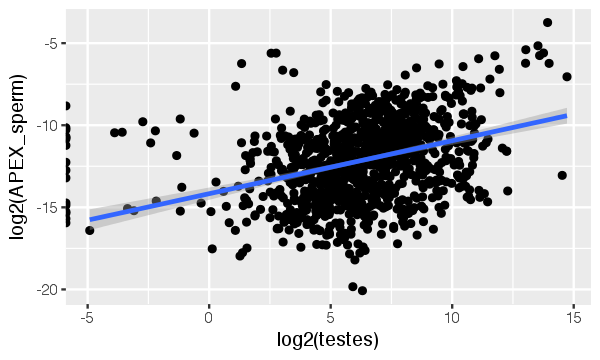

Warning message:
"Removed 434 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 406 rows containing missing values (geom_point)."

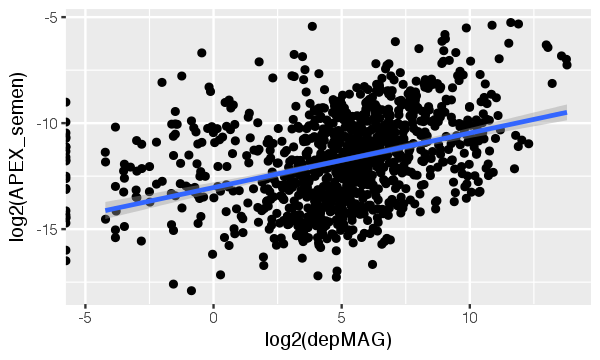

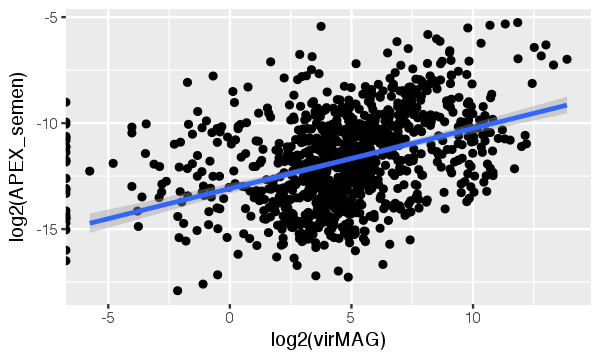

In [94]:
ggplot(apex_RNAseq, aes(log2(testes), log2(APEX_sperm))) + geom_point() + geom_smooth(method = "lm")
ggplot(apex_RNAseq, aes(log2(depMAG), log2(APEX_semen))) + geom_point() + geom_smooth(method = "lm")
ggplot(apex_RNAseq, aes(log2(virMAG), log2(APEX_semen))) + geom_point() + geom_smooth(method = "lm")

In [95]:
sperm.meanTPM = subset(meanTPMmatrix, rownames(meanTPMmatrix) %in% rownames(sperm_elements_factor_df))
sperm.meanTPM = subset(sperm.meanTPM, rowSums(sperm.meanTPM) > 10)

semen.meanTPM = subset(meanTPMmatrix, rownames(meanTPMmatrix) %in% rownames(semen_elements_factor_df))
semen.meanTPM = subset(semen.meanTPM, rowSums(semen.meanTPM) > 10)

Now a heatmap for sperm:

for plotting:: min.raw: -1 max.raw: 1


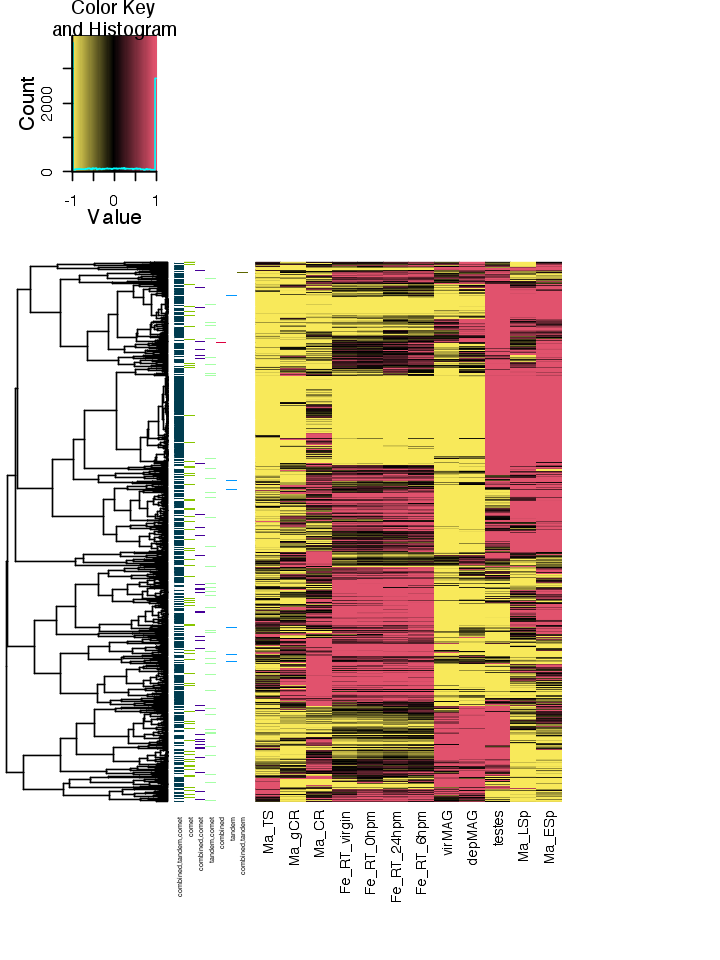

In [96]:
data = sperm.meanTPM
gene_factors = unique(sperm_elements_factor_df[,1])
gene_factor_colors = rainbow(length(gene_factors))
names(gene_factor_colors) = gene_factors
data = log2(data+1)
data = as.matrix(data) # convert to matrix
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
myheatcol = colorpanel(75, '#f8e95a','black','#e1526d')
data = t(scale(t(data), scale=F)) # center rows, mean substracted
heatmap_data = data
gene_factor_row_vals = as.factor(sperm_elements_factor_df[rownames(heatmap_data),])
names(gene_factor_row_vals) = rownames(heatmap_data)
gene_factors_here = unique(gene_factor_row_vals)
names(gene_factors_here) = gene_factors_here
num_gene_factors_here = length(gene_factors_here)
geneFactorColors = c("#003c4f",
"#88c600",
"#460098",
"#a6ffa6",
"#dc0040",
"#0197ff",
"#5d6600",
"#eb90ff",
"#67000c",
"#ffc5ae")
geneFactorAnnotations = matrix(nrow=nrow(heatmap_data), ncol=num_gene_factors_here)
for (i in 1:num_gene_factors_here) {
    geneFactorAnnotations[,i] = gene_factor_row_vals %in% gene_factors_here[i]
}
geneFactorAnnotations = apply(geneFactorAnnotations, 1:2, function(x) as.logical(x))
geneFactorAnnotations = t(sample_matrix_to_color_assignments(t(geneFactorAnnotations), col=geneFactorColors))
rownames(geneFactorAnnotations) = rownames(heatmap_data)
colnames(geneFactorAnnotations) = gene_factors_here
heatmap_data[heatmap_data < -1] = -1
heatmap_data[heatmap_data > 1] = 1

options(repr.plot.width = 6, repr.plot.height = 8)
par(mfrow=c(1,2))
heatmap.3(heatmap_data, dendrogram = "row", Rowv=as.dendrogram(hc_genes), ,col=myheatcol, RowSideColors=geneFactorAnnotations, scale="none", density.info="histogram", trace="none", key=TRUE, cexCol=1, margins=c(10,10), cexRow=0.5, labRow = F)

And semen:

for plotting:: min.raw: -1 max.raw: 1


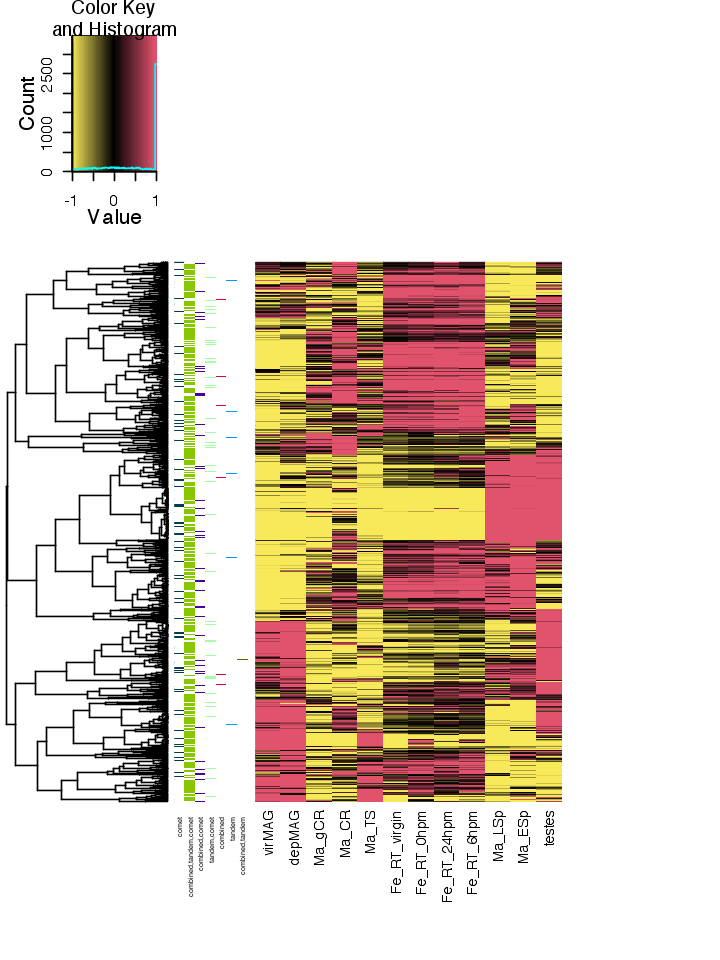

In [97]:
data = semen.meanTPM
gene_factors = unique(semen_elements_factor_df[,1])
gene_factor_colors = rainbow(length(gene_factors))
names(gene_factor_colors) = gene_factors
data = log2(data+1)
data = as.matrix(data) # convert to matrix
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
myheatcol = colorpanel(75, '#f8e95a','black','#e1526d')
data = t(scale(t(data), scale=F)) # center rows, mean substracted
heatmap_data = data
gene_factor_row_vals = as.factor(semen_elements_factor_df[rownames(heatmap_data),])
names(gene_factor_row_vals) = rownames(heatmap_data)
gene_factors_here = unique(gene_factor_row_vals)
names(gene_factors_here) = gene_factors_here
num_gene_factors_here = length(gene_factors_here)
geneFactorColors = c("#003c4f",
"#88c600",
"#460098",
"#a6ffa6",
"#dc0040",
"#0197ff",
"#5d6600",
"#eb90ff",
"#67000c",
"#ffc5ae")
geneFactorAnnotations = matrix(nrow=nrow(heatmap_data), ncol=num_gene_factors_here)
for (i in 1:num_gene_factors_here) {
    geneFactorAnnotations[,i] = gene_factor_row_vals %in% gene_factors_here[i]
}
geneFactorAnnotations = apply(geneFactorAnnotations, 1:2, function(x) as.logical(x))
geneFactorAnnotations = t(sample_matrix_to_color_assignments(t(geneFactorAnnotations), col=geneFactorColors))
rownames(geneFactorAnnotations) = rownames(heatmap_data)
colnames(geneFactorAnnotations) = gene_factors_here
heatmap_data[heatmap_data < -1] = -1
heatmap_data[heatmap_data > 1] = 1

options(repr.plot.width = 6, repr.plot.height = 8)
heatmap.3(heatmap_data, dendrogram = "row", Rowv=as.dendrogram(hc_genes), ,col=myheatcol, RowSideColors=geneFactorAnnotations, scale="none", density.info="histogram", trace="none", key=TRUE, cexCol=1, margins=c(10,10), cexRow=0.5, labRow = F)

Now let's look at the semen.only and sperm.only samples:

In [98]:
semen.only = subset(proteome_data, semen.only == 1)$gene
sperm.only = subset(proteome_data, sperm.only == 1)$gene

Get MSTRG IDs:

In [99]:
semen.only_mstrg = unique(subset(ref_to_gene, loc_ID %in% semen.only)$mstrg_ID)
sperm.only_mstrg = unique(subset(ref_to_gene, loc_ID %in% sperm.only)$mstrg_ID)

Now we can look at the expression plots for each group (include Sirot matrix). First extract the TPM matrices:

In [100]:
sperm.only.meanTPM = subset(meanTPMmatrix, rownames(meanTPMmatrix) %in% sperm.only_mstrg)
sperm.only.meanTPM = subset(sperm.only.meanTPM, rowSums(sperm.only.meanTPM) > 10)

semen.only.meanTPM = subset(meanTPMmatrix, rownames(meanTPMmatrix) %in% semen.only_mstrg)
semen.only.meanTPM = subset(semen.only.meanTPM, rowSums(semen.only.meanTPM) > 10)

sirot.SFPs.meanTPM = subset(meanTPMmatrix, rownames(meanTPMmatrix) %in% sirot_SFPs_mstrg)
sirot.SFPs.meanTPM = subset(sirot.SFPs.meanTPM, rowSums(sirot.SFPs.meanTPM) > 10)

sirot.sperm.meanTPM = subset(meanTPMmatrix, rownames(meanTPMmatrix) %in% sirot_Sps_mstrg)
sirot.sperm.meanTPM = subset(sirot.sperm.meanTPM, rowSums(sirot.sperm.meanTPM) > 10)

Now the heatmaps:

for plotting:: min.raw: -1 max.raw: 1


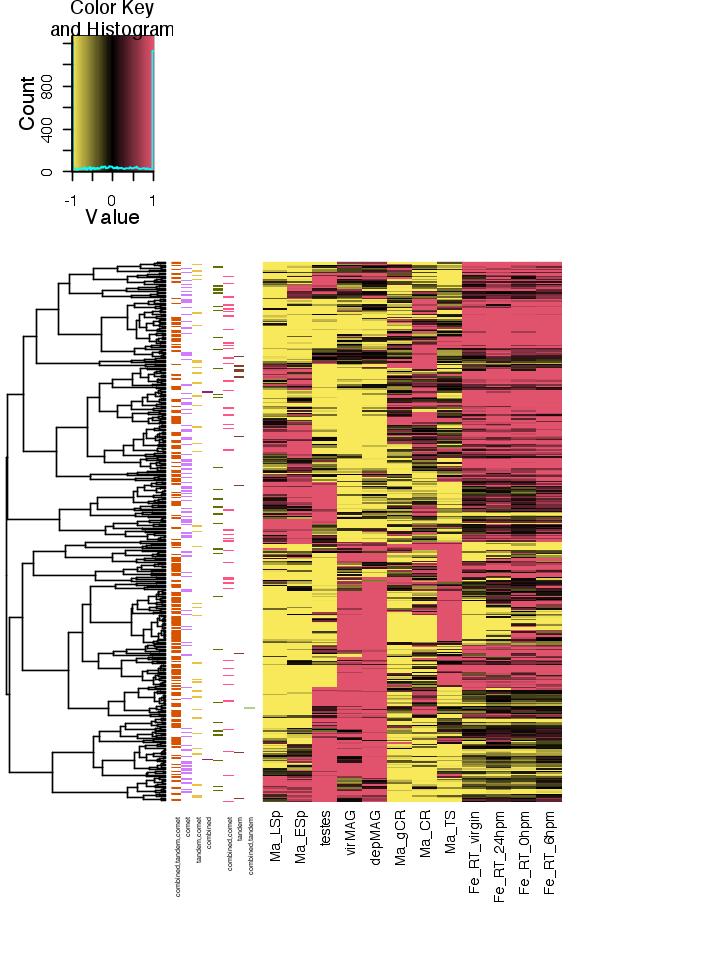

In [101]:
data = semen.only.meanTPM
gene_factors = unique(semen_elements_factor_df[,1])
gene_factor_colors = rainbow(length(gene_factors))
names(gene_factor_colors) = gene_factors
data = log2(data+1)
data = as.matrix(data) # convert to matrix
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
myheatcol = colorpanel(75, '#f8e95a','black','#e1526d')
data = t(scale(t(data), scale=F)) # center rows, mean substracted
heatmap_data = data
gene_factor_row_vals = as.factor(semen_elements_factor_df[rownames(heatmap_data),])
names(gene_factor_row_vals) = rownames(heatmap_data)
gene_factors_here = unique(gene_factor_row_vals)
names(gene_factors_here) = gene_factors_here
num_gene_factors_here = length(gene_factors_here)
geneFactorColors = c("#d85300","#d17bff","#ebc243","#92246e","#616e00","#ff5584","#80412a", "#afd186")
geneFactorAnnotations = matrix(nrow=nrow(heatmap_data), ncol=num_gene_factors_here)
for (i in 1:num_gene_factors_here) {
    geneFactorAnnotations[,i] = gene_factor_row_vals %in% gene_factors_here[i]
}
geneFactorAnnotations = apply(geneFactorAnnotations, 1:2, function(x) as.logical(x))
geneFactorAnnotations = t(sample_matrix_to_color_assignments(t(geneFactorAnnotations), col=geneFactorColors))
rownames(geneFactorAnnotations) = rownames(heatmap_data)
colnames(geneFactorAnnotations) = gene_factors_here
heatmap_data[heatmap_data < -1] = -1
heatmap_data[heatmap_data > 1] = 1

options(repr.plot.width = 6, repr.plot.height = 8)
heatmap.3(heatmap_data, dendrogram = "row", Rowv=as.dendrogram(hc_genes), ,col=myheatcol, RowSideColors=geneFactorAnnotations, scale="none", density.info="histogram", trace="none", key=TRUE, cexCol=1, margins=c(10,10), cexRow=0.5, labRow = F)

And sperm:

for plotting:: min.raw: -1 max.raw: 1


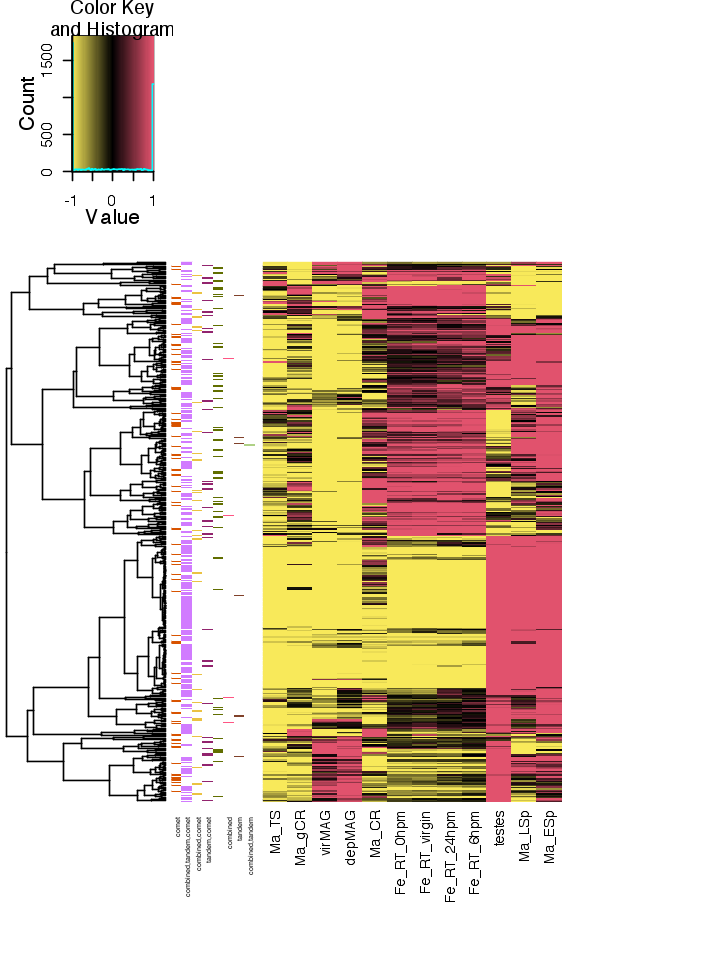

In [102]:
data = sperm.only.meanTPM
gene_factors = unique(sperm_elements_factor_df[,1])
gene_factor_colors = rainbow(length(gene_factors))
names(gene_factor_colors) = gene_factors
data = log2(data+1)
data = as.matrix(data) # convert to matrix
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
myheatcol = colorpanel(75, '#f8e95a','black','#e1526d')
data = t(scale(t(data), scale=F)) # center rows, mean substracted
heatmap_data = data
gene_factor_row_vals = as.factor(sperm_elements_factor_df[rownames(heatmap_data),])
names(gene_factor_row_vals) = rownames(heatmap_data)
gene_factors_here = unique(gene_factor_row_vals)
names(gene_factors_here) = gene_factors_here
num_gene_factors_here = length(gene_factors_here)
geneFactorColors = c("#d85300","#d17bff","#ebc243","#92246e","#616e00","#ff5584","#80412a", "#afd186")
geneFactorAnnotations = matrix(nrow=nrow(heatmap_data), ncol=num_gene_factors_here)
for (i in 1:num_gene_factors_here) {
    geneFactorAnnotations[,i] = gene_factor_row_vals %in% gene_factors_here[i]
}
geneFactorAnnotations = apply(geneFactorAnnotations, 1:2, function(x) as.logical(x))
geneFactorAnnotations = t(sample_matrix_to_color_assignments(t(geneFactorAnnotations), col=geneFactorColors))
rownames(geneFactorAnnotations) = rownames(heatmap_data)
colnames(geneFactorAnnotations) = gene_factors_here
heatmap_data[heatmap_data < -1] = -1
heatmap_data[heatmap_data > 1] = 1

options(repr.plot.width = 6, repr.plot.height = 8)
heatmap.3(heatmap_data, dendrogram = "row", Rowv=as.dendrogram(hc_genes), ,col=myheatcol, RowSideColors=geneFactorAnnotations, scale="none", density.info="histogram", trace="none", key=TRUE, cexCol=1, margins=c(10,10), cexRow=0.5, labRow = F)

Now Sirot's:

for plotting:: min.raw: -1 max.raw: 1


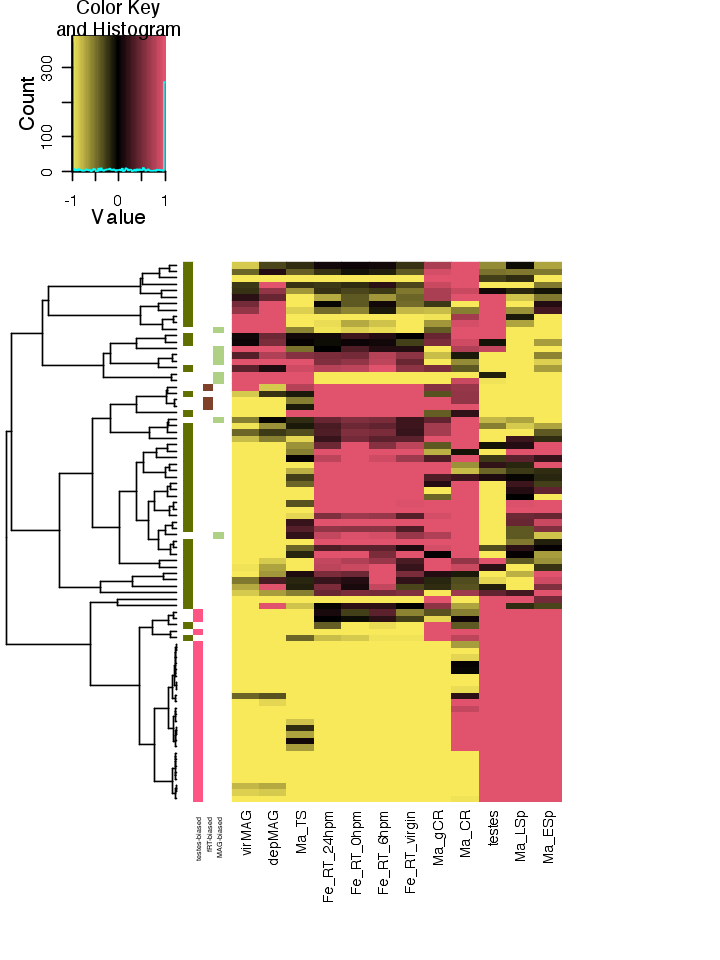

In [103]:
data = sirot.sperm.meanTPM
gene_factors = unique(factor.labeling[,1])
gene_factor_colors = rainbow(length(gene_factors))
names(gene_factor_colors) = gene_factors
data = log2(data+1)
data = as.matrix(data) # convert to matrix
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
myheatcol = colorpanel(75, '#f8e95a','black','#e1526d')
data = t(scale(t(data), scale=F)) # center rows, mean substracted
heatmap_data = data
gene_factor_row_vals = as.factor(factor.labeling[rownames(heatmap_data),])
names(gene_factor_row_vals) = rownames(heatmap_data)
gene_factors_here = unique(gene_factor_row_vals)
names(gene_factors_here) = gene_factors_here
num_gene_factors_here = length(gene_factors_here)
geneFactorColors = c("#616e00","#ff5584","#80412a", "#afd186")
geneFactorAnnotations = matrix(nrow=nrow(heatmap_data), ncol=num_gene_factors_here)
for (i in 1:num_gene_factors_here) {
    geneFactorAnnotations[,i] = gene_factor_row_vals %in% gene_factors_here[i]
}
geneFactorAnnotations = apply(geneFactorAnnotations, 1:2, function(x) as.logical(x))
geneFactorAnnotations = t(sample_matrix_to_color_assignments(t(geneFactorAnnotations), col=geneFactorColors))
rownames(geneFactorAnnotations) = rownames(heatmap_data)
colnames(geneFactorAnnotations) = gene_factors_here
heatmap_data[heatmap_data < -1] = -1
heatmap_data[heatmap_data > 1] = 1

options(repr.plot.width = 6, repr.plot.height = 8)
heatmap.3(heatmap_data, dendrogram = "row", Rowv=as.dendrogram(hc_genes), ,col=myheatcol, RowSideColors=geneFactorAnnotations, scale="none", density.info="histogram", trace="none", key=TRUE, cexCol=1, margins=c(10,10), cexRow=0.5, labRow = F)

for plotting:: min.raw: -1 max.raw: 1


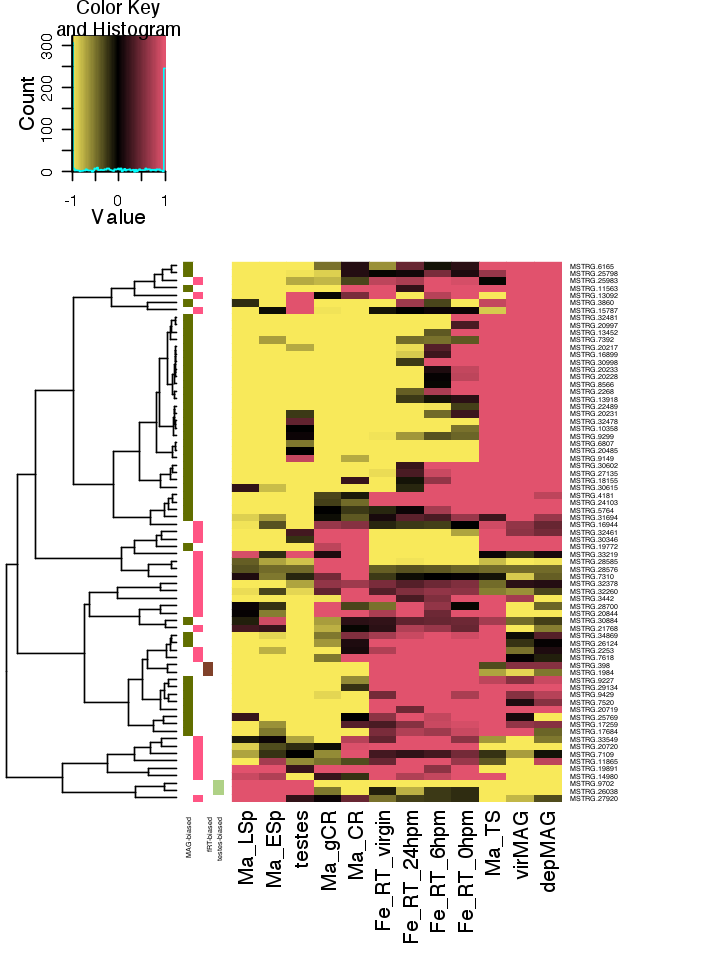

In [104]:
data = sirot.SFPs.meanTPM
gene_factors = unique(factor.labeling[,1])
gene_factor_colors = rainbow(length(gene_factors))
names(gene_factor_colors) = gene_factors
data = log2(data+1)
data = as.matrix(data) # convert to matrix
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
myheatcol = colorpanel(75, '#f8e95a','black','#e1526d')
data = t(scale(t(data), scale=F)) # center rows, mean substracted
heatmap_data = data
gene_factor_row_vals = as.factor(factor.labeling[rownames(heatmap_data),])
names(gene_factor_row_vals) = rownames(heatmap_data)
gene_factors_here = unique(gene_factor_row_vals)
names(gene_factors_here) = gene_factors_here
num_gene_factors_here = length(gene_factors_here)
geneFactorColors = c("#616e00","#ff5584","#80412a", "#afd186")
geneFactorAnnotations = matrix(nrow=nrow(heatmap_data), ncol=num_gene_factors_here)
for (i in 1:num_gene_factors_here) {
    geneFactorAnnotations[,i] = gene_factor_row_vals %in% gene_factors_here[i]
}
geneFactorAnnotations = apply(geneFactorAnnotations, 1:2, function(x) as.logical(x))
geneFactorAnnotations = t(sample_matrix_to_color_assignments(t(geneFactorAnnotations), col=geneFactorColors))
rownames(geneFactorAnnotations) = rownames(heatmap_data)
colnames(geneFactorAnnotations) = gene_factors_here
heatmap_data[heatmap_data < -1] = -1
heatmap_data[heatmap_data > 1] = 1

options(repr.plot.width = 6, repr.plot.height = 8)
heatmap.3(heatmap_data, dendrogram = "row", Rowv=as.dendrogram(hc_genes), ,col=myheatcol, RowSideColors=geneFactorAnnotations, scale="none", density.info="histogram", trace="none", key=TRUE, cexCol=1.5, margins=c(10,10), cexRow=0.5)

### GO analysis on the proteome data:

First create a factor labeling table with VectorBase IDs:

In [105]:
ejaculotome_factor_df = as.data.frame(unlist(ejaculotome_elements))
ejaculotome_factor_df$source = gsub('[[:digit:]]+', '', rownames(ejaculotome_factor_df))
ejaculotome_factor_df = as.data.frame(as.list(ejaculotome_factor_df))
ejaculotome_factor_df = merge(proteome_IDs, ejaculotome_factor_df, by.x = "loc_ID", by.y = "unlist.ejaculotome_elements.")

There are 16 proteins in the NCBI annotation that didn't make it to the VectorBase annotation. They are almost all "LOW QUALITY PROTEINS". Here are some of them:

In [106]:
subset(ref_to_gene, loc_ID %in% subset(ejaculotome_factor_df, is.na(gene_ID))$loc_ID)

,gene_ID,RefSeq_protein,mstrg_ID,transcript_ID,loc_ID,GenBank_description,gene_name,VB_description
34403,NA,XP_021705224.1,NA,rna23395,LOC5563635,LOW QUALITY PROTEIN: atypical kinase COQ8B%2C mitochondrial,NA,NA
34988,NA,XP_001650993.1,NA,rna27389,LOC5566596,LOW QUALITY PROTEIN: ubiquitin-like modifier-activating enzyme 1,NA,NA
35170,NA,XP_021706606.1,NA,rna21468,LOC5567647,LOW QUALITY PROTEIN: spectrin beta chain%2C non-erythrocytic 5,NA,NA
35281,NA,XP_021697020.1,NA,rna10047,LOC5574825,LOW QUALITY PROTEIN: ATP-binding cassette sub-family B member 8%2C mitochondrial,NA,NA
35392,NA,XP_021697398.1,NA,rna2295,LOC110675833,vesicle-associated membrane protein/synaptobrevin-binding protein-like,NA,NA
35395,NA,XP_001653501.2,NA,rna11443,LOC5571184,LOW QUALITY PROTEIN: FAD-linked sulfhydryl oxidase ALR,NA,NA
35685,NA,XP_021707922.1,NA,rna23982,LOC110678814,diacylglycerol kinase eta-like,NA,NA
36061,NA,XP_021708504.1,NA,rna26788,LOC5579853,LOW QUALITY PROTEIN: spectrin beta chain,NA,NA
37187,NA,XP_021700494.1,NA,rna15171,LOC5576948,LOW QUALITY PROTEIN: uncharacterized protein LOC5576948,NA,NA
37590,NA,XP_021701099.1,NA,rna16146,LOC5566990,LOW QUALITY PROTEIN: myosin heavy chain%2C muscle,NA,NA


We should remove those from the factor labeling table first:

In [107]:
ejaculotome_factor_df = subset(ejaculotome_factor_df, !is.na(gene_ID))
rownames(ejaculotome_factor_df) = ejaculotome_factor_df$gene_ID
ejaculotome_factor_df = subset(ejaculotome_factor_df, select = "source")

Now we can run the GO analysis on the sperm only proteins, semen only proteins, and the shared sperm/semen proteins:

In [108]:
ejaculotome_factor_list = unique(ejaculotome_factor_df[,1])

GO_enriched_list = list()

for (feature_cat in ejaculotome_factor_list) {
    message('Processing category: ', feature_cat)
    cat_genes_vec = as.integer(features_with_GO %in% rownames(ejaculotome_factor_df)[ejaculotome_factor_df$source == feature_cat])
    pwf$DEgenes = cat_genes_vec
    res = goseq(pwf,gene2cat=GO_info_listed)
    ## over-represented categories:
    pvals = res$over_represented_pvalue
    pvals[pvals > 1 -1e-10] = 1-1e-10
    q = qvalue(pvals)
    res$over_represented_FDR = q$qvalues
    go_enrich_factor = feature_cat
    enrich_result_table = res[res$over_represented_pvalue<=0.05,]
    descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
    enrich_result_table$go_term = descr
    enrich_result_table$factor = go_enrich_factor
    GO_enriched_list[[feature_cat]] = enrich_result_table
}

GO_enrichment_data = rbindlist(GO_enriched_list)


Processing category: semen,sperm
Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns
Processing category: sperm
Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns
Processing category: semen
Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


First we'll plot the sperm only enriched GO terms:

Warning message:
"Removed 21 rows containing missing values (geom_point)."Warning message:
"Removed 1 rows containing missing values (geom_text_repel)."Warning message:
"Removed 3 rows containing missing values (geom_text_repel)."Warning message:
"Removed 17 rows containing missing values (geom_text_repel)."

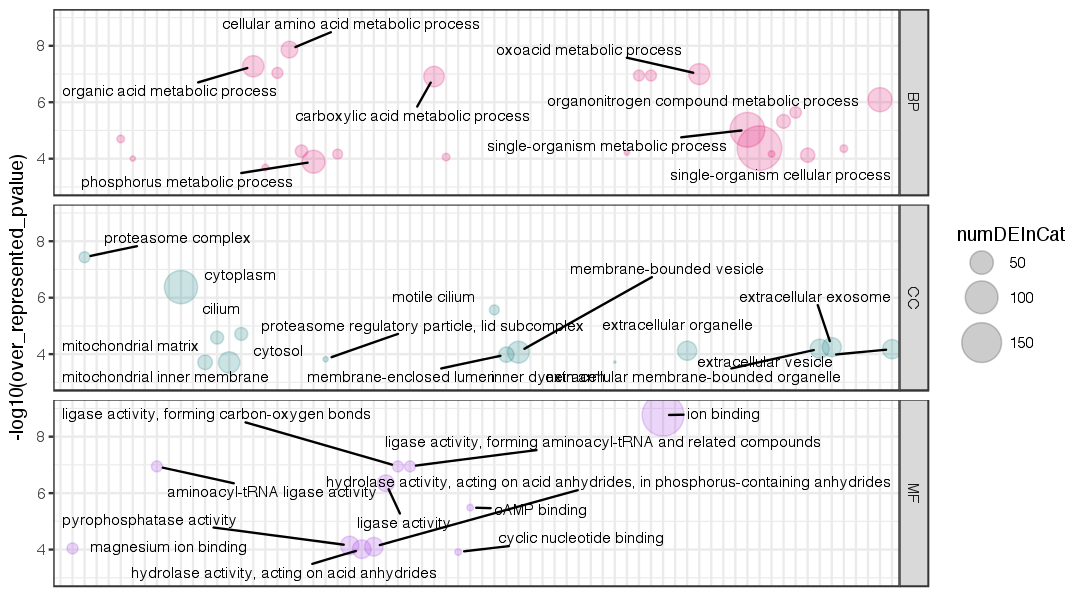

In [109]:
options(repr.plot.width = 9, repr.plot.height = 5)
ggplot(subset(GO_enrichment_data, over_represented_FDR < 0.05 & factor == "sperm"), 
       aes(category, -log10(over_represented_pvalue), size = numDEInCat, colour = ontology)) + 
    geom_point(alpha = 0.2)  + 
    facet_grid(ontology~.) +
    xlab(NULL) + 
    geom_text_repel(data = subset(GO_enrichment_data, over_represented_FDR < 0.05 & numDEInCat > 20 & ontology == "BP" & factor == "sperm"), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 30, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) + 
    geom_text_repel(data = subset(GO_enrichment_data, over_represented_FDR < 0.05 & ontology == "CC" & factor == "sperm"), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 30, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) + 
    geom_text_repel(data = subset(GO_enrichment_data, over_represented_FDR < 0.05  & ontology == "MF" & factor == "sperm"), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 30, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) + 
#     scale_size(range=c(-3,8)) +
    theme_bw() +
    theme(axis.text.x = element_blank(), axis.ticks.x = element_blank()) + 
    scale_size(range = c(0,12)) + 
    scale_colour_manual(values=c("#e00068",
                                 "#01777b",
                                 "#9d31e4")) +
    guides(colour = FALSE) +
    scale_y_continuous(limits=c(3, 9))

Now for semen:

Warning message:
"Removed 2 rows containing missing values (geom_point)."Warning message:
"Removed 1 rows containing missing values (geom_text_repel)."Warning message:
"Removed 1 rows containing missing values (geom_text_repel)."

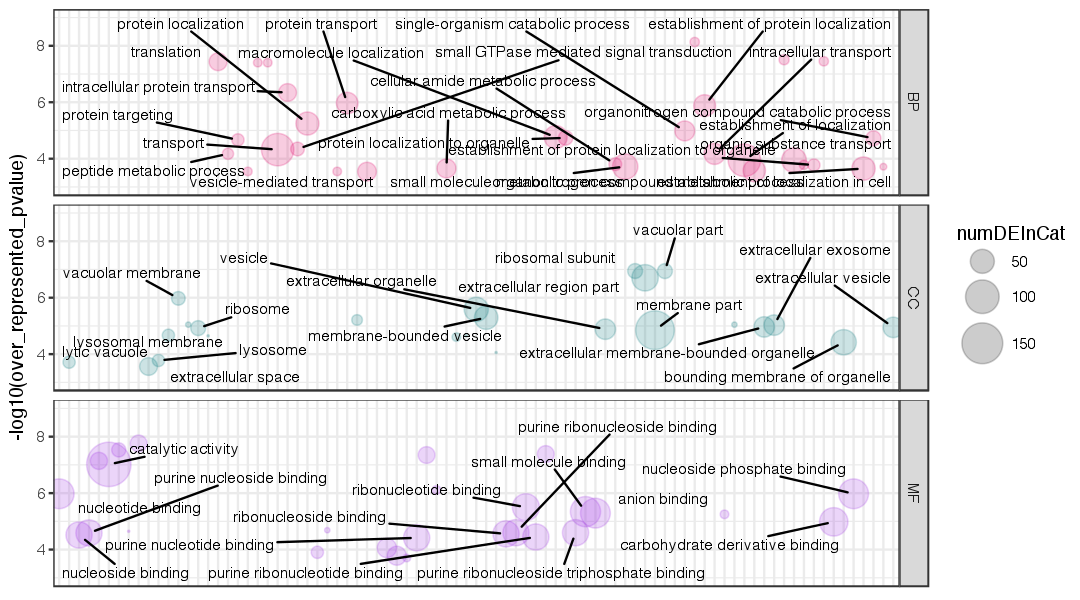

In [110]:
options(repr.plot.width = 9, repr.plot.height = 5)
ggplot(subset(GO_enrichment_data, over_represented_FDR < 0.05 & factor == "semen"), 
       aes(category, -log10(over_represented_pvalue), size = numDEInCat, colour = ontology)) + 
    geom_point(alpha = 0.2)  + 
    facet_grid(ontology~.) +
    xlab(NULL) + 
    geom_text_repel(data = subset(GO_enrichment_data, over_represented_FDR < 0.05 & numDEInCat > 10 & ontology == "BP" & factor == "semen"), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 30, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) + 
    geom_text_repel(data = subset(GO_enrichment_data, over_represented_FDR < 0.05 & numDEInCat > 10 & ontology == "CC" & factor == "semen"), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 30, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) + 
    geom_text_repel(data = subset(GO_enrichment_data, over_represented_FDR < 0.05 & numDEInCat > 50 & ontology == "MF" & factor == "semen"), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 30, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) + 
#     scale_size(range=c(-3,8)) +
    theme_bw() +
    theme(axis.text.x = element_blank(), axis.ticks.x = element_blank()) + 
    scale_size(range = c(0,12)) + 
    scale_colour_manual(values=c("#e00068",
                                 "#01777b",
                                 "#9d31e4")) +
    guides(colour = FALSE) +
    scale_y_continuous(limits=c(3, 9))

Finally, for shared proteins:

Warning message:
"Removed 106 rows containing missing values (geom_point)."Warning message:
"Removed 22 rows containing missing values (geom_text_repel)."Warning message:
"Removed 29 rows containing missing values (geom_text_repel)."Warning message:
"Removed 27 rows containing missing values (geom_text_repel)."

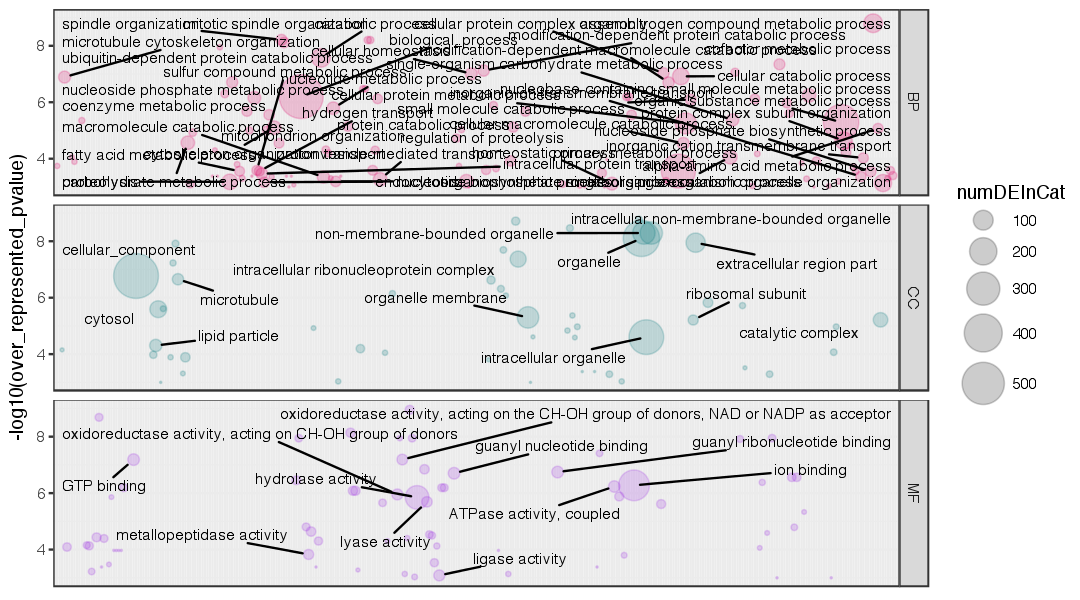

In [111]:
options(repr.plot.width = 9, repr.plot.height = 5)
ggplot(subset(GO_enrichment_data, over_represented_FDR < 0.05 & factor == "semen,sperm"), 
       aes(category, -log10(over_represented_pvalue), size = numDEInCat, colour = ontology)) + 
    geom_point(alpha = 0.2)  + 
    facet_grid(ontology~.) +
    xlab(NULL) + 
    geom_text_repel(data = subset(GO_enrichment_data, over_represented_FDR < 0.05 & numDEInCat > 20 & ontology == "BP" & factor == "semen,sperm"), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 30, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) + 
    geom_text_repel(data = subset(GO_enrichment_data, over_represented_FDR < 0.05 & numDEInCat > 20 & ontology == "CC" & factor == "semen,sperm"), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 30, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) + 
    geom_text_repel(data = subset(GO_enrichment_data, over_represented_FDR < 0.05 & numDEInCat > 20 & ontology == "MF" & factor == "semen,sperm"), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 30, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) + 
#     scale_size(range=c(-3,8)) +
    theme_bw() +
    theme(axis.text.x = element_blank(), axis.ticks.x = element_blank()) + 
    scale_size(range = c(0,12)) + 
    scale_colour_manual(values=c("#e00068",
                                 "#01777b",
                                 "#9d31e4")) +
    guides(colour = FALSE) +
    scale_y_continuous(limits=c(3, 9))

It's clear from doing it this way that the overlap includes most of the semen and/or sperm proteins. The GO analysis should be run separately on all protein in the sperm proteome, and all proteins in the semen proteome. First we'll set up factor labeling for sperm and semen separately:

In [112]:
sperm_factor_df = subset(ejaculotome_factor_df, grepl("sperm", ejaculotome_factor_df$source))
sperm_factor_df$source = "sperm"
semen_factor_df = subset(ejaculotome_factor_df, grepl("semen", ejaculotome_factor_df$source))
semen_factor_df$source = "semen"

In [113]:
cat_genes_vec = as.integer(features_with_GO %in% rownames(ejaculotome_factor_df)[ejaculotome_factor_df$source == "semen"])
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
go_enrich_factor = "semen"
enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
enrich_result_table$go_term = descr
enrich_result_table$factor = go_enrich_factor

Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


We'll create a heatmap for plotting the ejaculotome's gene expression profile across the samples. First subset the TPM matrix

In [193]:
ejaculotome.meanTPM = subset(meanTPMmatrix, rownames(meanTPMmatrix) %in% proteome_IDs$mstrg_ID)
ejaculotome.meanTPM = subset(ejaculotome.meanTPM, rowSums(ejaculotome.meanTPM) > 10)

Now make a new factor labeling table:

In [245]:
n.ejaculotome_factor_df = ejaculotome_factor_df
n.ejaculotome_factor_df$gene_ID = rownames(n.ejaculotome_factor_df)
n.ejaculotome_factor_df = merge(n.ejaculotome_factor_df, proteome_IDs, by.x = "gene_ID", by.y = "gene_ID")
n.ejaculotome_factor_df = subset(n.ejaculotome_factor_df, select = c("source", "mstrg_ID"))
n.ejaculotome_factor_df = n.ejaculotome_factor_df[!duplicated(n.ejaculotome_factor_df$mstrg_ID),]

In [246]:
# n.ejaculotome_factor_df = as.matrix(subset(n.ejaculotome_factor_df, !is.na("mstrg_ID")))
rownames(n.ejaculotome_factor_df) = n.ejaculotome_factor_df$mstrg_ID
n.ejaculotome_factor_df = subset(n.ejaculotome_factor_df, select = "source")

In [247]:
head(n.ejaculotome_factor_df)

,source
MSTRG.24859,sperm
MSTRG.24787,semen
MSTRG.24791,"semen,sperm"
MSTRG.24856,sperm
MSTRG.24788,"semen,sperm"
MSTRG.24875,semen


for plotting:: min.raw: -1 max.raw: 1


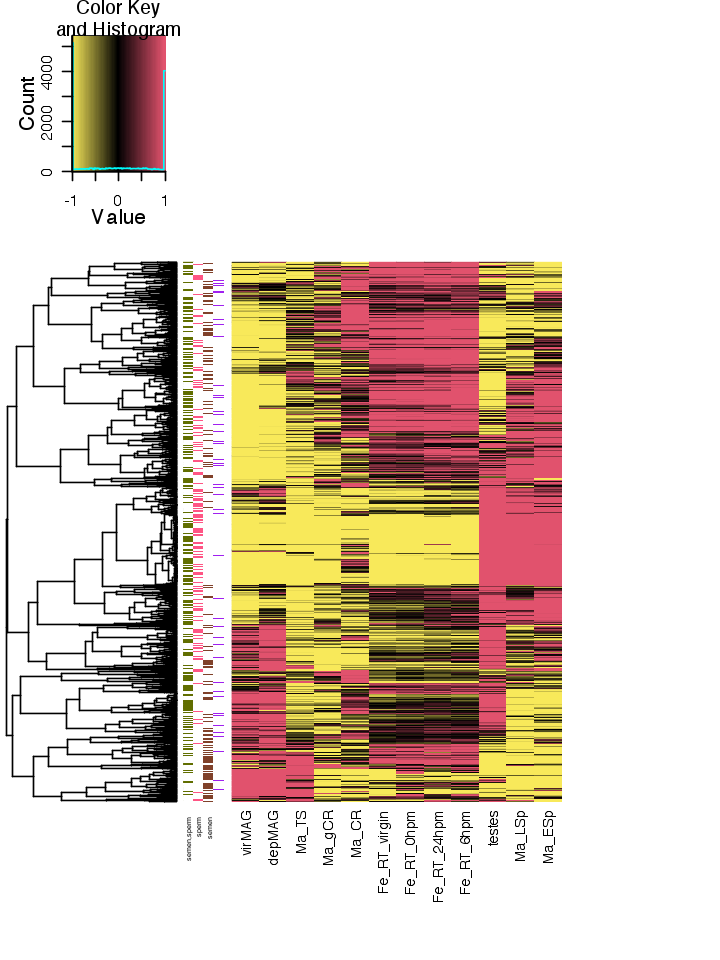

In [249]:
data = ejaculotome.meanTPM
gene_factors = unique(n.ejaculotome_factor_df[,1])
gene_factor_colors = rainbow(length(gene_factors))
names(gene_factor_colors) = gene_factors
data = log2(data+1)
data = as.matrix(data) # convert to matrix
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
myheatcol = colorpanel(75, '#f8e95a','black','#e1526d')
data = t(scale(t(data), scale=F)) # center rows, mean substracted
heatmap_data = data
gene_factor_row_vals = as.factor(n.ejaculotome_factor_df[rownames(heatmap_data),])
names(gene_factor_row_vals) = rownames(heatmap_data)
gene_factors_here = unique(gene_factor_row_vals)
names(gene_factors_here) = gene_factors_here
num_gene_factors_here = length(gene_factors_here)
geneFactorColors = c("#616e00","#ff5584","#80412a", "purple")
geneFactorAnnotations = matrix(nrow=nrow(heatmap_data), ncol=num_gene_factors_here)
for (i in 1:num_gene_factors_here) {
    geneFactorAnnotations[,i] = gene_factor_row_vals %in% gene_factors_here[i]
}
geneFactorAnnotations = apply(geneFactorAnnotations, 1:2, function(x) as.logical(x))
geneFactorAnnotations = t(sample_matrix_to_color_assignments(t(geneFactorAnnotations), col=geneFactorColors))
rownames(geneFactorAnnotations) = rownames(heatmap_data)
colnames(geneFactorAnnotations) = gene_factors_here
heatmap_data[heatmap_data < -1] = -1
heatmap_data[heatmap_data > 1] = 1

options(repr.plot.width = 6, repr.plot.height = 8)
heatmap.3(heatmap_data, dendrogram = "row", Rowv=as.dendrogram(hc_genes), ,col=myheatcol, RowSideColors=geneFactorAnnotations, scale="none", density.info="histogram", trace="none", key=TRUE, cexCol=1, margins=c(10,10), cexRow=0.5, labRow = F)

## Chromosome distribution

First we'll add a chromosome arm identifier to `gene.features`:

In [ ]:
head(gene.features)

In [ ]:
options(repr.plot.width = 7, repr.plot.height = 3)
ggplot(subset(gene.features, gene_id %in% MAG.CDS.list & grepl("Chr", gene.features$chromosome)), aes(min, (max-min), colour = chromosome)) + geom_point() + facet_grid(.~chromosome, scales = "free")
ggplot(subset(gene.features, gene_id %in% testes.CDS.list & grepl("Chr", gene.features$chromosome)), aes(min, (max-min), colour = chromosome)) + geom_point() + facet_grid(.~chromosome, scales = "free")

We'll also subset the gene features for annotated genes, get the mean coordinate value, and include only genes with a single coordinate value:

In [ ]:
annot.features = unique(subset(gene.features, select = c("contig", "min", "max", "gene_name", "gene_id", "chromosome")))
annot.features$mean_coord = (annot.features$max + annot.features$min)/2
annot.features = as.data.frame(subset(annot.features, grepl("LOC", gene_name)))
annot.features = setDT(annot.features)[, .SD[which.max(mean_coord)], by=gene_name]

FIrst we'll calculate the total number of genes on the 3 major chromosomes:

In [ ]:
TotalGeneNumber = as.data.frame(table(factor(subset(annot.features, grepl("Chr", chromosome))$chromosome)))
colnames(TotalGeneNumber) = c("chromosome", "All genes")
total_genes = nrow(annot.features)
TotalGeneNumber$proportion = (TotalGeneNumber$`All genes`/total_genes)

In [ ]:
as.data.frame(table(factor(subset(annot.features, gene_name %in% MAG.LOC_IDs.list & grepl("Chr", chromosome))$chromosome)))

In [ ]:
genomeNumber.MAG = length(MAG.LOC_IDs.list)
chromNumber.MAG=as.data.frame(table(factor(subset(annot.features, gene_name %in% MAG.LOC_IDs.list & grepl("Chr", chromosome))$chromosome)))
colnames(chromNumber.MAG) = c("chromosome", "Observed_biased_genes")
chromNumber.MAG$tissue = "MAGs"
chromNumber.MAG = merge(TotalGeneNumber, chromNumber.MAG)
chromNumber.MAG$`Expected genes` = genomeNumber.MAG*chromNumber.MAG$proportion
chromNumber.MAG$`obs.exp` = chromNumber.MAG$Observed_biased_genes/chromNumber.MAG$`Expected genes`
chromNumber.MAG

In [ ]:
genomeNumber.testes = length(testes.LOC_IDs.list)
chromNumber.testes=as.data.frame(table(factor(subset(annot.features, gene_name %in% testes.LOC_IDs.list & grepl("Chr", chromosome))$chromosome)))
colnames(chromNumber.testes) = c("chromosome", "Observed_biased_genes")
chromNumber.testes$tissue = "Testes"
chromNumber.testes = merge(TotalGeneNumber, chromNumber.testes)
chromNumber.testes$`Expected genes` = genomeNumber.testes*chromNumber.testes$proportion
chromNumber.testes$`obs.exp` = chromNumber.testes$Observed_biased_genes/chromNumber.testes$`Expected genes`
chromNumber.testes

In [ ]:
tissue_biased.numbers = rbind(chromNumber.MAG, chromNumber.testes)


### Code to extract transcript with detectable expression in the testes or accessory glands

Subset the counts matrix with the appropriate samples for both tissues:

In [ ]:
MAG.counts.keep = subset(counts.keep, select=c("depMAG_1", "depMAG_2", "depMAG_3", "depMAG_4", "virMAG_1", "virMAG_2", "virMAG_3", "virMAG_4"))
testes.counts.keep = subset(counts.keep, select=c("testes_1", "testes_2", "testes_3", "testes_4"))

Now filter these subsetted count matrices:

In [ ]:
MAG.e.CPM <- cpm(MAG.counts.keep)
MAG.e.thresh <- MAG.e.CPM > 5
MAG.e.keep <- rowSums(MAG.e.thresh) >= 4
MAG.e.counts.keep <- MAG.counts.keep[MAG.e.keep,]
dim(MAG.e.counts.keep)

testes.e.CPM <- cpm(testes.counts.keep)
testes.e.thresh <- testes.e.CPM > 5
testes.e.keep <- rowSums(testes.e.thresh) >= 4
testes.e.counts.keep <- testes.counts.keep[testes.e.keep,]
dim(testes.e.counts.keep)

Finally, write out the files with the lists of gene names for each tissue:

In [ ]:
MAG_transcriptome = rownames(MAG.e.counts.keep)
MAG_transcriptome_list = unique(subset(gene.features, gene_id %in% rownames(MAG.e.counts.keep))$gene_name)
write.table(MAG_transcriptome_list, file = "MAG_transcriptome.list", row.names = F, col.names = F, quote = F)

testes_transcriptome = rownames(testes.e.counts.keep)
testes_transcriptome_list = unique(subset(gene.features, gene_id %in% rownames(testes.e.counts.keep))$gene_name)
write.table(testes_transcriptome_list, file = "testes_transcriptome.list", row.names = F, col.names = F, quote = F)

For both classes combined:

In [ ]:
testis_MAG_transcriptome = rownames(e.counts.keep)
testis_MAG_transcriptome_list = unique(subset(gene.features, gene_id %in% rownames(e.counts.keep))$gene_name)
#write.table(testis_MAG_transcriptome_list, file = "testis_MAG_transcriptome.list", row.names = F, col.names = F, quote = F)

## Popgen results:

In [257]:
mkData = read.table("../popgen_results/proteome.MK.results.withGeneID.txt", header = T, sep = "\t")

In [264]:
mkData$NS = mkData$NS_POLY + mkData$NS_FIX
mkData$S = mkData$S_POLY + mkData$S_FIX
mkData$propNS = mkData$NS /(mkData$NS + mkData$S)
head(mkData)

gene,TRANSCRIPT,NS_POLY,S_POLY,NS_FIX,S_FIX,codons,final_NI,alpha,final_FET,NS,S,propNS
AAEL000003,AAEL000003-RA.fa,7,63,1,16,655,1.7778,-0.7778,1.0000,8,79,0.09195402
AAEL000004,AAEL000004-RA.fa,9,20,0,4,512,0.0000,1.0000,0.5548,9,24,0.27272727
AAEL000006,AAEL000006-RA.fa,7,39,0,3,617,0.0000,1.0000,1.0000,7,42,0.14285714
AAEL000006,AAEL000006-RB.fa,8,40,0,0,616,0.0000,1.0000,1.0000,8,40,0.16666667
AAEL000006,AAEL000006-RC.fa,3,22,1,9,613,1.2273,-0.2273,1.0000,4,31,0.11428571
AAEL000010,AAEL000010-RA.fa,0,1,0,0,109,0.0000,1.0000,1.0000,0,1,0.00000000


OG_id,Aedes.aegypti.GeneID,Aedes.aegypti.gene.name,Aedes.albopictus,Anopheles.gambiae,Anopheles.albimanus,Culex.quinquefasciatus,Drosophila.melanogaster,Manduca.sexta,Apis.mellifera,Mus.musculus,Homo.sapiens,count
1,5569942,LOC5569942,109622862,1279452,AALB000881,6048482,FBgn0053196,Msex2.09193,551170,,,8
2,5573881,LOC5573881,109419798;109425333,1281535,AALB008645,6033676,FBgn0005666,Msex2.01810;Msex2.01810-RAA,409821,22138,7273,10
3,110674834,LOC110674834,109411751,1271352,AALB001346,,,Msex2.06395,551356,64009;319565,23345;23224,8
4,23687479,LOC23687479,109422269,1278301,AALB003958,6034268,FBgn0013733,Msex2.12693;Msex2.12690,408779,13518;11426,667;23499,10
5,5570236;5571179,LOC5570236;LOC5571179,109419627;109411815,1269667,AALB006229,6039276,FBgn0086906,Msex2.11630,551259;552504,,,8
7,,,,,AALB005231,6034598,,,,17996,4703,4


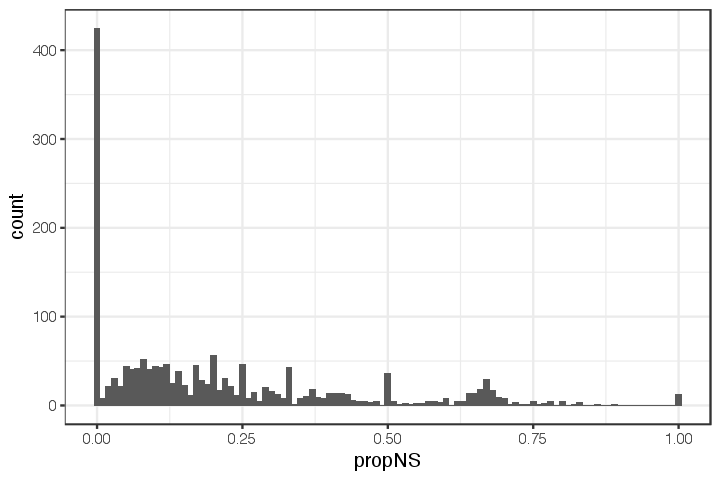

In [265]:
options(repr.plot.width = 6, repr.plot.height = 4)
ggplot(mkData, aes(propNS)) + geom_histogram(binwidth = 0.01) + theme_bw()

In [270]:
subset(mkData, final_FET < 0.05)

,gene,TRANSCRIPT,NS_POLY,S_POLY,NS_FIX,S_FIX,codons,final_NI,alpha,final_FET,NS,S,propNS
82,AAEL000770,AAEL000770-RA.fa,0,24,1,0,364,0.0000,1.0000,0.0400,1,24,0.04000000
231,AAEL002206,AAEL002206-RA.fa,2051,1093,0,5,1648,0.0000,1.0000,0.0051,2051,1098,0.65131788
235,AAEL002251,AAEL002251-RA.fa,1473,682,1,4,1554,8.6393,-7.6393,0.0378,1474,686,0.68240741
282,AAEL002727,AAEL002727-RA.fa,18,182,1499,625,1680,0.0412,0.9588,0.0000,1517,807,0.65275387
321,AAEL003046,AAEL003046-RA.fa,9,2,0,4,1023,0.0000,1.0000,0.0110,9,6,0.60000000
343,AAEL003213,AAEL003213-RA.fa,5,30,3,2,432,0.1111,0.8889,0.0457,8,32,0.20000000
713,AAEL006322,AAEL006322-RA.fa,909,461,0,10,642,0.0000,1.0000,0.0000,909,471,0.65869565
714,AAEL006322,AAEL006322-RB.fa,900,455,0,10,636,0.0000,1.0000,0.0000,900,465,0.65934066
761,AAEL006600,AAEL006600-RD.fa,7,31,2,0,433,0.0000,1.0000,0.0462,9,31,0.22500000
775,AAEL006763,AAEL006763-RA.fa,32,75,4,1,863,0.1067,0.8933,0.0362,36,76,0.32142857


In [ ]:
proteome_L5_to_L3 = unique(subset(subset(trinotate, AaegL3.4.blastX %in% unique(mkData$gene)), select = c("gene_name", "AaegL3.4.blastX")))

In [ ]:
tmpFile = merge(proteome_L5_to_L3, mkData, by.x = "AaegL3.4.blastX", by.y = "gene")

In [ ]:
nrow(subset(tmpFile, final_FET < 0.05))